In [1]:
!pip install tweepy
!pip install snscrape
!pip install selenium

# Importing Libraries

In [2]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import nltk
from nltk.corpus import stopwords
stop_nltk = stopwords.words("english")
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
stopwords = stopwords.words('english')
from nltk.stem import SnowballStemmer
stemmer_s = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DALVENDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:

import tweepy
import re
from operator import itemgetter

In [4]:
#Your Twittter App Credentials
consumer_key = "KZo8NjePIbgz3e7olBmsKKCig"
consumer_secret = "bI8KwcTSqLN9y7cJjzmsmTFOp3BqWp8MdOIokXX7zuFMKgKCdy"
access_token = "389089569-bafZxXvfThZuRU0SDetqu8r7fg2NxYYoxpiQbewX"
access_token_secret = "7MqVTanLGn8lZzVDizk4bu10NWyoJica38cXrdj8GWqxc"


In [5]:

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [6]:
api

# Extracting Twitter Comments

In [7]:
def get_tweet_ids(keyword,period,startDate,endDate,maxTweets):
    
    '''
    Function to scrape tweet ids for a given hashtag using snscrape
    '''
    f = os.system('snscrape --max-results '+str(maxTweets)+' twitter-hashtag '+'"'+keyword+' since:'+startDate+' until:'+endDate+'"'+' >fetched_tweet_ids_'+period+'_#'+keyword+'.txt')
    if f==0:
        print(f"Successfully fetched tweet ids for #{keyword}")

In [8]:
def fetch_tw(ids,keyword,period):
    
    '''
    Function to extract tweet attributes - id, text, date, hashtags, usermentions
    '''
    list_of_tw_status = api.statuses_lookup(id_=ids,tweet_mode="extended") #ids batch size limited to 100
    #time.sleep(5)
    empty_data = pd.DataFrame()
    
    for status in list_of_tw_status:
        
        if status.lang=='en': #getting only tweets in english
        
            #if str(status.created_at).split(' ')[0]>'2019-12-17':
                
            try:
                hashtags = list(map(itemgetter('text'),status.entities['hashtags'])) 
            except:
                hashtags=None
            try:
                user_mentions=status.entities['user_mentions'][0]['screen_name']
            except:
                user_mentions=None
                    
            tweet_elem = {"id":status.id,
                          "date":status.created_at,
                          "tweet":status.full_text,
                          "hashtags":str(hashtags).strip('[]'),
                          "usermentions":user_mentions}
            
        else:
            continue
        
        empty_data = empty_data.append(tweet_elem,ignore_index=True)
            
    empty_data.to_csv("fetched_tweets_"+period+'_#'+keyword+".csv", mode="a",index=False)

In [9]:
def get_tweets(keyword,period):
    
    '''
    Function to get tweet data using tweet ids
    '''
 
    #Extracting ids from the tweet urls
    tweet_url = pd.read_csv("fetched_tweet_ids_"+period+"_#"+keyword+".txt", index_col= None, header = None, names = ["links"])
    af = lambda x: x["links"].split("/")[-1]
    tweet_url['id'] = tweet_url.apply(af, axis=1)
    ids = tweet_url['id'].tolist()
    
    # Processing the ids in batches
    total_count = len(ids)
    chunks = (total_count - 1) // 50 + 1
    for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch,keyword,period)
        print(f'Batch {i+1} processed successfully...')

In [10]:
def get_processed_tweets(keywords,period,startDate,endDate,maxTweets):

    '''
    Function to get processed tweets
    '''
    
    # Importing dependent functions
    
    for keyword in keywords:
        
        get_tweet_ids(keyword,period,startDate,endDate,maxTweets)

        get_tweets(keyword,period)
        
    # Merging all records from csv files of different hashtags
    
    tweets = []
    
    for keyword in keywords:
    
        df = pd.read_csv('fetched_tweets_'+period+'_#'+keyword+'.csv',index_col=None,header=0)
        tweets.append(df)
        
    tweet_data = pd.concat(tweets,axis=0,ignore_index=True)
    
    tweet_data.columns = ['Date_time','Hashtags','ID','Tweet_text','Usermentions'] # Naming columns

    # Removing repetitive headers
    indices = tweet_data[tweet_data['Tweet_text']=='tweet'].index
    tweet_data.drop(indices,inplace=True)
    
    # Removing duplicate records keeping the first one
    tweet_data.drop_duplicates("ID",inplace=True)

    # Converting to datetime object
    tweet_data['Date'] = tweet_data['Date_time'].str.split(" ",expand=True)[0]
    tweet_data = tweet_data.drop(['Date_time'],axis=1)
    tweet_data['Date'] = pd.to_datetime(tweet_data['Date'],infer_datetime_format=True)
    
    # Removing rows that fall outside of the date range
    tweet_data = tweet_data[(tweet_data['Date']>=startDate) & (tweet_data['Date']<=endDate)]
    
    # Converting IDs to integers
    tweet_data['ID'] = [int(float(i)) for i in tweet_data['ID'].to_list()] # Conversion from scientific to integer notation

    # Rearranging columns
    tweet_data = tweet_data[['ID','Date','Tweet_text','Hashtags','Usermentions']]
    
    # Sorting rows based on date
    tweet_data.sort_values(ascending=False, by="Date",inplace=True)

    return tweet_data

Pre-Covid Period: Jul 1,2019 to Feb 29,2020 &
Post-covid Period: Mar 1,2020 to Present

In [13]:
# List of hashtags to search (equivalent to 'OR')
keywords = ['hondamotorcycles','hondahornet','hondadio','hondaactiva','hondagrazia','hondaunicorn',
            'hondashine','hondaSP125','hondaCD110','hondaLivo','hondaCBR650R','CBRFireblade','hondaXBlade','hondaCB1000R',
            'hondaAfricaTwin','hondaGoldWing','@honda2wheelerin']

periods = ['precovid','postcovid']
dates = ['2019-07-01','2020-02-29','2020-03-01',str(datetime.date.today())]
maxTweets = 100000

In [14]:
pre_covid_tweets = get_processed_tweets(keywords,periods[0],dates[0],dates[1],maxTweets)

Successfully fetched tweet ids for #hondamotorcycles
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Successfully fetched tweet ids for #hondahornet
Batch 1 processed successfully...
Batch 2 processed successfully...
Successfully fetched tweet ids for #hondadio
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Successfully fetched tweet ids

In [15]:
post_covid_tweets = get_processed_tweets(keywords,periods[1],dates[2],dates[3],maxTweets)

Successfully fetched tweet ids for #hondamotorcycles
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...
Batch 23 processed successfully...
Batch 24 processed successfully...
Batch 25 processed successfully...
Batch 26 processed successfully...
Batch 27 processed successfully...
Batch 28 pr

In [16]:
pre_covid_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
1561,1233339100666585088,2020-02-28,@BigWingIndia @honda2wheelerin What will be th...,NaN,BigWingIndia
1556,1233317730557845504,2020-02-28,@honda2wheelerin I have had a very bad experie...,"'worst', 'poor'",honda2wheelerin
1584,1233203719602225152,2020-02-28,@honda2wheelerin writing to you since December...,NaN,honda2wheelerin
1583,1233342781088681984,2020-02-28,@honda2wheelerin No spare part available in pu...,NaN,honda2wheelerin
1582,1233346764444319744,2020-02-28,@honda2wheelerin @Shivani95625196 It seems lik...,NaN,honda2wheelerin
...,...,...,...,...,...
579,1145784676151250944,2019-07-01,Summer evenings in maximum attack mode. #honda...,"'hondamotorcycles', 'cb1000bigone', 'custombik...",NaN
9589,1145739419577487360,2019-07-01,@honda2wheelerin I didn't accepted this cheap ...,NaN,honda2wheelerin
9606,1145739097824083968,2019-07-01,@honda2wheelerin what a cheap service are you ...,NaN,honda2wheelerin
9605,1145738132123340800,2019-07-01,@honda2wheelerin I had booked the honda CBR250...,NaN,honda2wheelerin


In [17]:
post_covid_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
2420,1339806726745309184,2020-12-18,@honda2wheelerin Still no update. What the hel...,NaN,honda2wheelerin
2387,1339911868383592448,2020-12-18,"@iSubhomoy31 Hello, \nStay tuned to our page f...",NaN,iSubhomoy31
2384,1339911304769761280,2020-12-18,"@ASHOKBHOGAL3 Hi Ashok, \nPlease allow us some...",NaN,ASHOKBHOGAL3
2383,1339909157240012800,2020-12-18,"@GodhwaniYash Hello, \nWe are glad your query ...",NaN,GodhwaniYash
2382,1339963796425744384,2020-12-18,"@honda2wheelerin as an owner of Honda Activa, ...",NaN,honda2wheelerin
...,...,...,...,...,...
1645,1234132763525165056,2020-03-01,Yes it is the new #HondaActiva 6G. You guessed...,"'HondaActiva', 'MotorBeam'",NaN
16156,1234018294337765376,2020-03-01,@honda2wheelerin @honda2wheelers \n\nWorst Exp...,'Pethtic',honda2wheelerin
16154,1234049757590409216,2020-03-01,Congratulations and wish you a safe riding exp...,"'kannur', 'honda', 'kerala', 'india'",cannanorehonda
16153,1234150934219051008,2020-03-01,Unprofessional and Rude behavior of Yug Honda ...,NaN,honda2wheelerin


# Text Processing

In [77]:
stop_updated = stop_nltk + ["bike","Honda","honda","motorcycle","biker","customercare","customer care","complaint","team","assist","complaint number","india","call","prompt","issue","details","custom care","amp","rt","rider","ride","video","review","please",
                           "hai","bro","bhai","itchi boot","numberplatekeychain","customkeychain","keychain",
                           "keychainshub","keychainlov","gelkeychain","motorbik","hero","twoWheeler","two","wheeler","Two Wheeer","bad","harleydavidson","send","wait","prioriti","hello","sincere","kind","address","detail","service center","request","103","1800","com","3434","new","get","would","look","updat","complet","number","time","also","dear","day","unfavor","back","reach"]

stemmer_s = SnowballStemmer("english")

In [78]:
# Use https://www.regexpal.com/ to test regular expressions

def clean_text(line):
    
    '''
    Function to clean text
    '''
    # Removing links,special characters, etc. using regular expressions
    text = re.sub("#[A-Za-z0-9]+"," ",line) # Removing hashtags first
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",text)
    tokens = text.lower().strip().split()  #strip() removes white spaces before and after the text
    stemmed = [stemmer_s.stem(term) for term in tokens \
               if term not in stop_updated and \
               len(term)>2]
    return ' '.join(stemmed)

In [79]:
pre_covid_tweets['Cleaned_text'] = pre_covid_tweets['Tweet_text'].apply(clean_text)
pre_covid_tweets[['Date','Tweet_text','Cleaned_text']]

,Date,Tweet_text,Cleaned_text
1561,2020-02-28,@BigWingIndia @honda2wheelerin What will be th...,expect sale figur year unit bring xre 190 300
1556,2020-02-28,@honda2wheelerin I have had a very bad experie...,experi servic use big name sale servic poor cu...
1584,2020-02-28,@honda2wheelerin writing to you since December...,write sinc decemb everytim repli concern resol...
1583,2020-02-28,@honda2wheelerin No spare part available in pu...,spare part avail pune showroom bs6 shine sp125
1582,2020-02-28,@honda2wheelerin @Shivani95625196 It seems lik...,seem like auto msg get month see attach say so...
...,...,...,...
579,2019-07-01,Summer evenings in maximum attack mode. #honda...,summer even maximum attack mode cotswold area ...
9589,2019-07-01,@honda2wheelerin I didn't accepted this cheap ...,accept cheap servic
9606,2019-07-01,@honda2wheelerin what a cheap service are you ...,cheap servic provid custom whenev call tell da...
9605,2019-07-01,@honda2wheelerin I had booked the honda CBR250...,book cbr250 red ab version 1st may showroom sa...


In [80]:
post_covid_tweets['Cleaned_text'] = post_covid_tweets['Tweet_text'].apply(clean_text)
post_covid_tweets[['Date','Tweet_text','Cleaned_text']]

,Date,Tweet_text,Cleaned_text
2420,2020-12-18,@honda2wheelerin Still no update. What the hel...,still updat hell go done 3rd class dealer mont...
2387,2020-12-18,"@iSubhomoy31 Hello, \nStay tuned to our page f...",stay tune page updat excit upcom launch sincer...
2384,2020-12-18,"@ASHOKBHOGAL3 Hi Ashok, \nPlease allow us some...",ashok allow check updat soon sincer 2wheeler
2383,2020-12-18,"@GodhwaniYash Hello, \nWe are glad your query ...",glad queri resolv alway queri sincer wheeler
2382,2020-12-18,"@honda2wheelerin as an owner of Honda Activa, ...",owner activa may know servic interv year old a...
...,...,...,...
1645,2020-03-01,Yes it is the new #HondaActiva 6G. You guessed...,yes guess right come much await featur
16156,2020-03-01,@honda2wheelerin @honda2wheelers \n\nWorst Exp...,worst experi even get vehicl deliveri vehicl d...
16154,2020-03-01,Congratulations and wish you a safe riding exp...,congratul wish safe ride experi sale 902045405...
16153,2020-03-01,Unprofessional and Rude behavior of Yug Honda ...,unprofession rude behavior yug wakad branch ma...


In [81]:
all_tweets = pd.concat([pre_covid_tweets,post_covid_tweets])
all_tweets.sort_values(ascending=False, by="Date",inplace=True)
all_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions,Cleaned_text
2396,1339941018179813376,2020-12-18,@honda2wheelerin I called got contact for main...,NaN,honda2wheelerin,call got contact main dealer popular chennai t...
2433,1339858812556042240,2020-12-18,No kannada language support @honda2wheelerin a...,NaN,honda2wheelerin,kannada languag support custom execut talk eng...
2430,1339795012482023424,2020-12-18,@honda2wheelerin Yep you need 2 days to check ...,NaN,honda2wheelerin,yep need day check think delay process
2429,1339851546683576320,2020-12-18,Now engine oil leakage and silencer holder bol...,NaN,honda2wheelerin,engin oil leakag silenc holder bolt broken sho...
2421,1339723570952323072,2020-12-18,@BigWingIndia @honda2wheelerin @BigWingIndia H...,NaN,BigWingIndia,like know launch cbr500r cb500x model realli l...
...,...,...,...,...,...,...
9635,1145702992571617280,2019-07-01,@honda2wheelerin Very bad experience in buying...,'hondagrazia',honda2wheelerin,experi buy one month buy face unsound ride eve...
9636,1145708664432390144,2019-07-01,@honda2wheelerin Very bad experience buying #h...,"'hondagrazia', 'pilothonda', 'honda2wheelerin'",honda2wheelerin,experi buy frm dealer given use damag vehicl upst
9638,1145573023002423296,2019-07-01,The best Mileage. The most Stylish. The most p...,"'honda', 'hondabikes', 'hondacbshinesp', 'nell...",honda2wheelerin,best mileag stylish power grab shine lakshmi p...
9637,1145643786929758208,2019-07-01,"Congratulations to our rider, Marc Marquez for...",NaN,NaN,congratul marc marquez claim remark podium fin...


In [82]:
pre_covid_comb_tweets=" ".join(pre_covid_tweets.Cleaned_text.values)
pre_covid_comb_tweets[:300]

'expect sale figur year unit bring xre 190 300 experi servic use big name sale servic poor custom support servic write sinc decemb everytim repli concern resolv provid solut concern repli like still wait final resolut side spare part avail pune showroom bs6 shine sp125 seem like auto msg get month se'

In [83]:
post_covid_comb_tweets=" ".join(post_covid_tweets.Cleaned_text.values)
post_covid_comb_tweets[:500]

'still updat hell go done 3rd class dealer month vehicl stay tune page updat excit upcom launch sincer 2wheeler ashok allow check updat soon sincer 2wheeler glad queri resolv alway queri sincer wheeler owner activa may know servic interv year old activa stay tune page updat excit upcom launch sincer 2wheeler manufactur defect purchas sp125 regard rais day ago till date receiv updat rajlani total understand concern deepli regret inconveni caus alreadi share concern depart assur queri shall resolv '

In [84]:
comb_tweets=pre_covid_comb_tweets+post_covid_comb_tweets
comb_tweets[:500]

'expect sale figur year unit bring xre 190 300 experi servic use big name sale servic poor custom support servic write sinc decemb everytim repli concern resolv provid solut concern repli like still wait final resolut side spare part avail pune showroom bs6 shine sp125 seem like auto msg get month see attach say someth solut regret troubl gone quick concern prioriti sincer wheeler go drop one weekend happi friday kind let know resolut mention mani time still unawar thnx ad fifth product bs6 line '

In [85]:
comb_tweets=" ".join((pre_covid_comb_tweets,post_covid_comb_tweets))
comb_tweets[:500]

'expect sale figur year unit bring xre 190 300 experi servic use big name sale servic poor custom support servic write sinc decemb everytim repli concern resolv provid solut concern repli like still wait final resolut side spare part avail pune showroom bs6 shine sp125 seem like auto msg get month see attach say someth solut regret troubl gone quick concern prioriti sincer wheeler go drop one weekend happi friday kind let know resolut mention mani time still unawar thnx ad fifth product bs6 line '

# Extracting tweets of official twitter handle

In [86]:
def get_tweet_ids1(keyword,period,startDate,endDate,maxTweets):
    
    '''
    Function to scrape tweet ids for a given hashtag using snscrape
    '''
    f = os.system('snscrape --max-results '+str(maxTweets)+' twitter-user '+'"'+keyword+' since:'+startDate+' until:'+endDate+'"'+' >fetched_tweet_ids_'+period+'_@'+keyword+'.txt')
    if f==0:
        print(f"Successfully fetched tweet ids for @{keyword}")

In [87]:
def fetch_tw1(ids,keyword,period):
    
    '''
    Function to extract tweet attributes - id, text, date, hashtags, usermentions
    '''
    list_of_tw_status = api.statuses_lookup(id_=ids,tweet_mode="extended") #ids batch size limited to 100
    #time.sleep(5)
    empty_data = pd.DataFrame()
    
    for status in list_of_tw_status:
        
        if status.lang=='en': #getting only tweets in english
        
            #if str(status.created_at).split(' ')[0]>'2019-12-17':
                
            try:
                hashtags = list(map(itemgetter('text'),status.entities['hashtags'])) 
            except:
                hashtags=None
            try:
                user_mentions=status.entities['user_mentions'][0]['screen_name']
            except:
                user_mentions=None
                    
            tweet_elem = {"id":status.id,
                          "date":status.created_at,
                          "tweet":status.full_text,
                          "hashtags":str(hashtags).strip('[]'),
                          "usermentions":user_mentions}
            
        else:
            continue
        
        empty_data = empty_data.append(tweet_elem,ignore_index=True)
            
    empty_data.to_csv("fetched_tweets_"+period+'_@'+keyword+".csv", mode="a",index=False)

In [88]:
def get_tweets1(keyword,period):
    
    '''
    Function to get tweet data using tweet ids
    '''
 
    #Extracting ids from the tweet urls
    tweet_url = pd.read_csv("fetched_tweet_ids_"+period+"_@"+keyword+".txt", index_col= None, header = None, names = ["links"])
    af = lambda x: x["links"].split("/")[-1]
    tweet_url['id'] = tweet_url.apply(af, axis=1)
    ids = tweet_url['id'].tolist()
    
    # Processing the ids in batches
    total_count = len(ids)
    chunks = (total_count - 1) // 50 + 1
    for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw1(batch,keyword,period)
        print(f'Batch {i+1} processed successfully...')

In [89]:
def get_processed_tweets1(keywords,period,startDate,endDate,maxTweets):

    '''
    Function to get processed tweets
    '''
    
    # Importing dependent functions
    
    for keyword in keywords:
        
        get_tweet_ids1(keyword,period,startDate,endDate,maxTweets)

        get_tweets1(keyword,period)
        
    # Merging all records from csv files of different hashtags
    
    tweets = []
    
    for keyword in keywords:
    
        df = pd.read_csv('fetched_tweets_'+period+'_@'+keyword+'.csv',index_col=None,header=0)
        tweets.append(df)
        
    tweet_data = pd.concat(tweets,axis=0,ignore_index=True)
    
    tweet_data.columns = ['Date_time','Hashtags','ID','Tweet_text','Usermentions'] # Naming columns

    # Removing repetitive headers
    indices = tweet_data[tweet_data['Tweet_text']=='tweet'].index
    tweet_data.drop(indices,inplace=True)
    
    # Removing duplicate records keeping the first one
    tweet_data.drop_duplicates("ID",inplace=True)

    # Converting to datetime object
    tweet_data['Date'] = tweet_data['Date_time'].str.split(" ",expand=True)[0]
    tweet_data = tweet_data.drop(['Date_time'],axis=1)
    tweet_data['Date'] = pd.to_datetime(tweet_data['Date'],infer_datetime_format=True)
    
    # Removing rows that fall outside of the date range
    tweet_data = tweet_data[(tweet_data['Date']>=startDate) & (tweet_data['Date']<=endDate)]
    
    # Converting IDs to integers
    tweet_data['ID'] = [int(float(i)) for i in tweet_data['ID'].to_list()] # Conversion from scientific to integer notation

    # Rearranging columns
    tweet_data = tweet_data[['ID','Date','Tweet_text','Hashtags','Usermentions']]
    
    # Sorting rows based on date
    tweet_data.sort_values(ascending=False, by="Date",inplace=True)

    return tweet_data

In [90]:
# Getting tweets of a particular user
keywords = ['honda2wheelerin']

periods = ['precovid','postcovid']
dates = ['2019-07-01','2020-02-29','2020-03-01',str(datetime.date.today())]
maxTweets = 100000

In [30]:
pre_covid_off_tweets = get_processed_tweets1(keywords,periods[0],dates[0],dates[1],maxTweets)

Successfully fetched tweet ids for @honda2wheelerin
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...
Batch 23 processed successfully...
Batch 24 processed successfully...
Batch 25 processed successfully...
Batch 26 processed successfully...
Batch 27 processed successfully...
Batch 28 pro

In [32]:
pre_covid_off_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
37,1233277208342351872,2020-02-28,"@puru_sunada Dear Purushotham,\nThanks for get...",NaN,puru_sunada
7,1233270759407046656,2020-02-28,"@Connect_Irshad Hi Irshad, \nStay tuned to our...",NaN,Connect_Irshad
17,1233313240177762304,2020-02-28,@bhushanvighne We regret the trouble you have ...,NaN,bhushanvighne
16,1233275282426978304,2020-02-28,@VireshMH206 Thank you for your interest in Ho...,NaN,VireshMH206
15,1233320145809862656,2020-02-28,"@amolkhelukar01 Hi Amol, \nWe regret the troub...",NaN,amolkhelukar01
...,...,...,...,...,...
1891,1146770816652021760,2019-07-04,"With the restyled Honda Grazia, maneuver effor...",NaN,NaN
1905,1146422555542114304,2019-07-03,Blaze the trails with Honda Africa Twin’s exce...,NaN,NaN
1906,1146043097555427328,2019-07-02,"With Honda Shield, embrace your riding experie...",NaN,NaN
1885,1145643786929758208,2019-07-01,"Congratulations to our rider, Marc Marquez for...",NaN,NaN


In [91]:
pre_covid_off_comp_tweets = pre_covid_off_tweets[pre_covid_off_tweets['Tweet_text'].str.split('@').str[0]!='']
pre_covid_off_comp_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
41,1233267997201928192,2020-02-28,India’s most loved scooter is here to change t...,'6Changesthegame',NaN
39,1233017077885071360,2020-02-27,Honda launches Fresh &amp; Powerful - Unicorn ...,NaN,NaN
43,1233014243265376256,2020-02-27,Welcome great savings upto ₹10000 on the Honda...,NaN,NaN
5,1232653076869206016,2020-02-26,"Unleash a phenomenal ride, the silent way with...",NaN,NaN
53,1231938522153512960,2020-02-24,Take on the road to a smooth ride and phenomen...,NaN,NaN
...,...,...,...,...,...
1891,1146770816652021760,2019-07-04,"With the restyled Honda Grazia, maneuver effor...",NaN,NaN
1905,1146422555542114304,2019-07-03,Blaze the trails with Honda Africa Twin’s exce...,NaN,NaN
1906,1146043097555427328,2019-07-02,"With Honda Shield, embrace your riding experie...",NaN,NaN
1885,1145643786929758208,2019-07-01,"Congratulations to our rider, Marc Marquez for...",NaN,NaN


In [92]:
pre_covid_off_user_tweets = pre_covid_off_tweets[pre_covid_off_tweets['Tweet_text'].str.split('@').str[0]=='']
pre_covid_off_user_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
37,1233277208342351872,2020-02-28,"@puru_sunada Dear Purushotham,\nThanks for get...",NaN,puru_sunada
7,1233270759407046656,2020-02-28,"@Connect_Irshad Hi Irshad, \nStay tuned to our...",NaN,Connect_Irshad
17,1233313240177762304,2020-02-28,@bhushanvighne We regret the trouble you have ...,NaN,bhushanvighne
16,1233275282426978304,2020-02-28,@VireshMH206 Thank you for your interest in Ho...,NaN,VireshMH206
15,1233320145809862656,2020-02-28,"@amolkhelukar01 Hi Amol, \nWe regret the troub...",NaN,amolkhelukar01
...,...,...,...,...,...
1896,1148226889737224192,2019-07-08,@Anupam12822492 We sincerely regret the inconv...,NaN,Anupam12822492
1889,1148225846131511296,2019-07-08,@Swapnil416011 We sincerely regret the inconve...,NaN,Swapnil416011
1894,1148225892176539648,2019-07-08,@kaustubh1014 We sincerely regret the inconven...,NaN,kaustubh1014
1893,1148223411132489728,2019-07-08,"@JithinPNinan1 Dear Jithin, \nWe sincerely reg...",NaN,JithinPNinan1


In [35]:
post_covid_off_tweets = get_processed_tweets1(keywords,periods[1],dates[2],dates[3],maxTweets)

Successfully fetched tweet ids for @honda2wheelerin
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...
Batch 23 processed successfully...
Batch 24 processed successfully...
Batch 25 processed successfully...
Batch 26 processed successfully...
Batch 27 processed successfully...
Batch 28 pro

In [93]:
post_covid_off_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
33,1340271187734134784,2020-12-19,"@iShubhashish Hello, \nWe apologize for the un...",NaN,iShubhashish
45,1340263229780447232,2020-12-19,"@atishay97027581 Hello, \nPlease allow us some...",NaN,atishay97027581
48,1340265967507570688,2020-12-19,"@sharmapradeep5g Hi Pradeep, \nThank you for s...",NaN,sharmapradeep5g
22,1340274176091803648,2020-12-19,"@ErManuGoswami Hello,\nThank you for your feed...",NaN,ErManuGoswami
23,1340281734810673152,2020-12-19,@bl_praveen You can check out all the details ...,NaN,bl_praveen
...,...,...,...,...,...
4855,1234342338559787008,2020-03-02,"@VetranS_Mouth @BigWingIndia Dear Paramjeet,\n...",NaN,VetranS_Mouth
4856,1234357621424934912,2020-03-02,@mahendra_bagul We regret the trouble you have...,NaN,mahendra_bagul
4865,1234366643729362944,2020-03-02,"@NaimishBairagi @akshaykumar Hi Naimish, \nWe ...",NaN,NaimishBairagi
4863,1234392612439609344,2020-03-02,@TARKESH12992710 Stay tuned to our page for mo...,NaN,TARKESH12992710


In [94]:
post_covid_off_comp_tweets = post_covid_off_tweets[post_covid_off_tweets['Tweet_text'].str.split('@').str[0]!='']
post_covid_off_comp_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
29,1340258073751867392,2020-12-19,"A new and sportier look, aggressive design and...",'KeepDIOingIt',NaN
83,1339553973359894528,2020-12-17,"Get 5% Cashback up to Rs 5,000 on Credit Card/...",'StrictlyForTheAdvanced',NaN
51,1339520847086817280,2020-12-17,You may also visit your nearest dealership for...,NaN,NaN
104,1338808523787018240,2020-12-15,#LiveLifeLivoStyle as you avail exciting offer...,'LiveLifeLivoStyle',NaN
162,1338446134545674240,2020-12-14,"With a sportier look and aggressive design, it...",'KeepDio',NaN
...,...,...,...,...,...
4776,1237004459378479104,2020-03-09,Celebrate the festival of colours in hues of s...,"'HappyHoli', 'Holi2020'",NaN
4800,1236278662359465984,2020-03-07,"This Women's Day, take your dreams to newer he...","'HappyWomensDay', 'InternationalWomensDay', 'E...",NaN
4825,1235560230118817792,2020-03-05,Save up to ₹10000 on on the Honda Activa i sco...,NaN,NaN
4798,1235206583807705088,2020-03-04,Honda 2 Wheelers India’s BS-VI sales zoom past...,NaN,NaN


In [95]:
post_covid_off_user_tweets = post_covid_off_tweets[post_covid_off_tweets['Tweet_text'].str.split('@').str[0]=='']
post_covid_off_user_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
33,1340271187734134784,2020-12-19,"@iShubhashish Hello, \nWe apologize for the un...",NaN,iShubhashish
45,1340263229780447232,2020-12-19,"@atishay97027581 Hello, \nPlease allow us some...",NaN,atishay97027581
48,1340265967507570688,2020-12-19,"@sharmapradeep5g Hi Pradeep, \nThank you for s...",NaN,sharmapradeep5g
22,1340274176091803648,2020-12-19,"@ErManuGoswami Hello,\nThank you for your feed...",NaN,ErManuGoswami
23,1340281734810673152,2020-12-19,@bl_praveen You can check out all the details ...,NaN,bl_praveen
...,...,...,...,...,...
4855,1234342338559787008,2020-03-02,"@VetranS_Mouth @BigWingIndia Dear Paramjeet,\n...",NaN,VetranS_Mouth
4856,1234357621424934912,2020-03-02,@mahendra_bagul We regret the trouble you have...,NaN,mahendra_bagul
4865,1234366643729362944,2020-03-02,"@NaimishBairagi @akshaykumar Hi Naimish, \nWe ...",NaN,NaimishBairagi
4863,1234392612439609344,2020-03-02,@TARKESH12992710 Stay tuned to our page for mo...,NaN,TARKESH12992710


In [96]:
all_off_comp_tweets = pd.concat([pre_covid_off_comp_tweets,post_covid_off_comp_tweets])
all_off_comp_tweets.sort_values(ascending=False, by="Date",inplace=True)
all_off_comp_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
29,1340258073751867392,2020-12-19,"A new and sportier look, aggressive design and...",'KeepDIOingIt',NaN
83,1339553973359894528,2020-12-17,"Get 5% Cashback up to Rs 5,000 on Credit Card/...",'StrictlyForTheAdvanced',NaN
51,1339520847086817280,2020-12-17,You may also visit your nearest dealership for...,NaN,NaN
104,1338808523787018240,2020-12-15,#LiveLifeLivoStyle as you avail exciting offer...,'LiveLifeLivoStyle',NaN
162,1338446134545674240,2020-12-14,"With a sportier look and aggressive design, it...",'KeepDio',NaN
...,...,...,...,...,...
1891,1146770816652021760,2019-07-04,"With the restyled Honda Grazia, maneuver effor...",NaN,NaN
1905,1146422555542114304,2019-07-03,Blaze the trails with Honda Africa Twin’s exce...,NaN,NaN
1906,1146043097555427328,2019-07-02,"With Honda Shield, embrace your riding experie...",NaN,NaN
1909,1145550093354823680,2019-07-01,"A refreshing take on style, Honda Grazia comes...",NaN,NaN


In [97]:
all_off_user_tweets = pd.concat([pre_covid_off_user_tweets,post_covid_off_user_tweets])
all_off_user_tweets.sort_values(ascending=False, by="Date",inplace=True)
all_off_user_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
45,1340263229780447232,2020-12-19,"@atishay97027581 Hello, \nPlease allow us some...",NaN,atishay97027581
13,1340262967686746112,2020-12-19,"@bl_praveen Hello,\nThank you for your feedbac...",NaN,bl_praveen
40,1340263915700146176,2020-12-19,"@roshan7174 Hi Roshan, \nThank you for sharing...",NaN,roshan7174
6,1340271550918848512,2020-12-19,"@narayanmishra13 Hello, \nThank you for sharin...",NaN,narayanmishra13
2,1340262531420438528,2020-12-19,"@rak2682 Hi Ramesh, \nPlease allow us some tim...",NaN,rak2682
...,...,...,...,...,...
1914,1148224549143699456,2019-07-08,@Yashmali @Honda @BigWingIndia @HondaESauto We...,NaN,Yashmali
1917,1148225579872903168,2019-07-08,@Jovanpreet We sincerely regret the inconvenie...,NaN,Jovanpreet
1901,1148226471711956992,2019-07-08,@shettyganesh36 We sincerely regret the inconv...,NaN,shettyganesh36
1903,1148224770011516928,2019-07-08,@TheSMehra @Yashmali @Honda @BigWingIndia @Hon...,NaN,TheSMehra


In [98]:
'''
FINAL DATASETS

pre_covid_tweets
post_covid_tweets
pre_covid_off_comp_tweets
post_covid_off_comp_tweets
pre_covid_off_user_tweets
post_covid_off_user_tweets
all_tweets
all_off_tweets

'''

# Exporting the processed data to csv files

pre_covid_tweets.to_csv(r'pre_covid_tweets.csv', index = False)
post_covid_tweets.to_csv(r'post_covid_tweets.csv', index = False)

pre_covid_off_tweets.to_csv(r'pre_covid_off_comp_tweets.csv', index = False)
post_covid_off_tweets.to_csv(r'post_covid_off_comp_tweets.csv', index = False)

pre_covid_off_user_tweets.to_csv(r'pre_covid_off_user_tweets.csv', index = False)
post_covid_off_user_tweets.to_csv(r'post_covid_off_user_tweets.csv', index = False)


all_tweets.to_csv(r'all_tweets.csv', index = False)
all_off_user_tweets.to_csv(r'all_off_user_tweets.csv', index = False)
all_off_comp_tweets.to_csv(r'all_off_comp_tweets.csv', index = False)

# Exploratory Data Analysis

In [99]:
#CREATING USER DEFINED WORDCLOUD

In [100]:
def get_wordcloud(df):
    
    comb_tweets = " ".join(df['Cleaned_text'].values)
    
    wordcloud = WordCloud(width=800,height=800,
                          stopwords=stop_updated,
                          background_color='white',
                          max_words=100,
                          normalize_plurals=True).generate_from_text(comb_tweets)
    
    return wordcloud


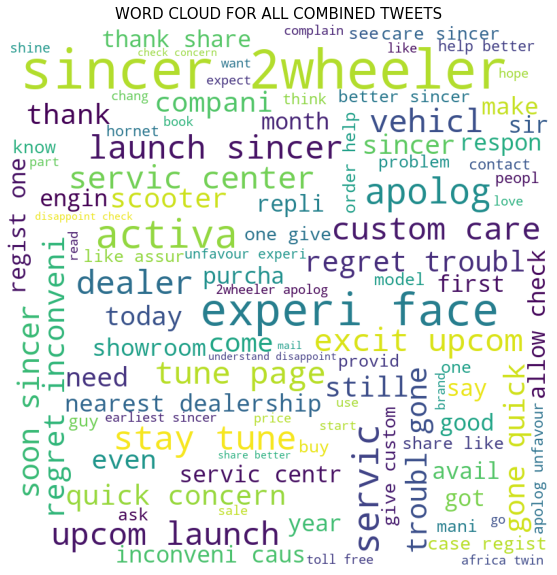

In [101]:
clouds = get_wordcloud(all_tweets)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR ALL COMBINED TWEETS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

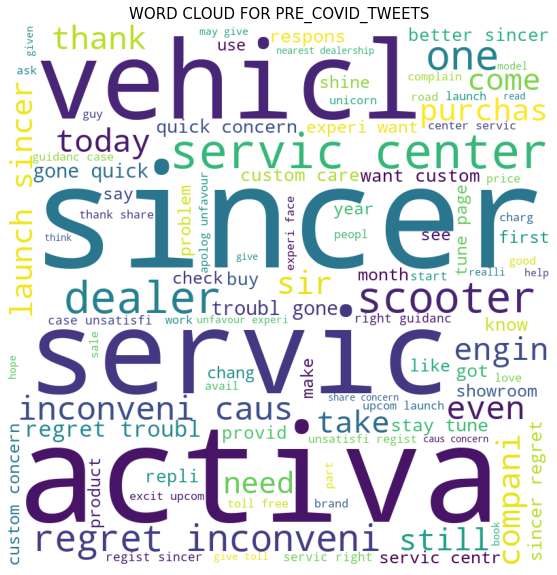

In [102]:
clouds = get_wordcloud(pre_covid_tweets)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR PRE_COVID_TWEETS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

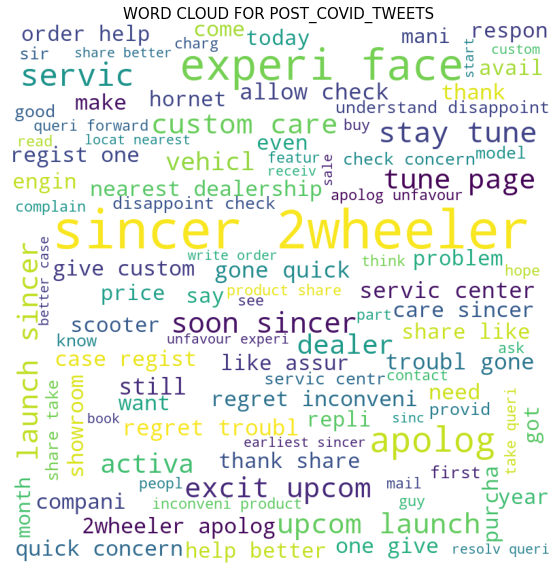

In [103]:
clouds = get_wordcloud(post_covid_tweets)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR POST_COVID_TWEETS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

In [104]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DALVENDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Frequency Distributions

In [105]:
def get_freqdist(df):
    comb_freqdist=" ".join(df['Cleaned_text'].values)
    all_terms= word_tokenize(comb_freqdist)
    fdist = FreqDist([x for x in all_terms if x not in stop_updated])
    df_dist = pd.DataFrame(fdist.items(), columns = ["words","freq"])
    df_dist.sort_values(ascending=False, by="freq",inplace=True)
    
    
    return df_dist
        

    

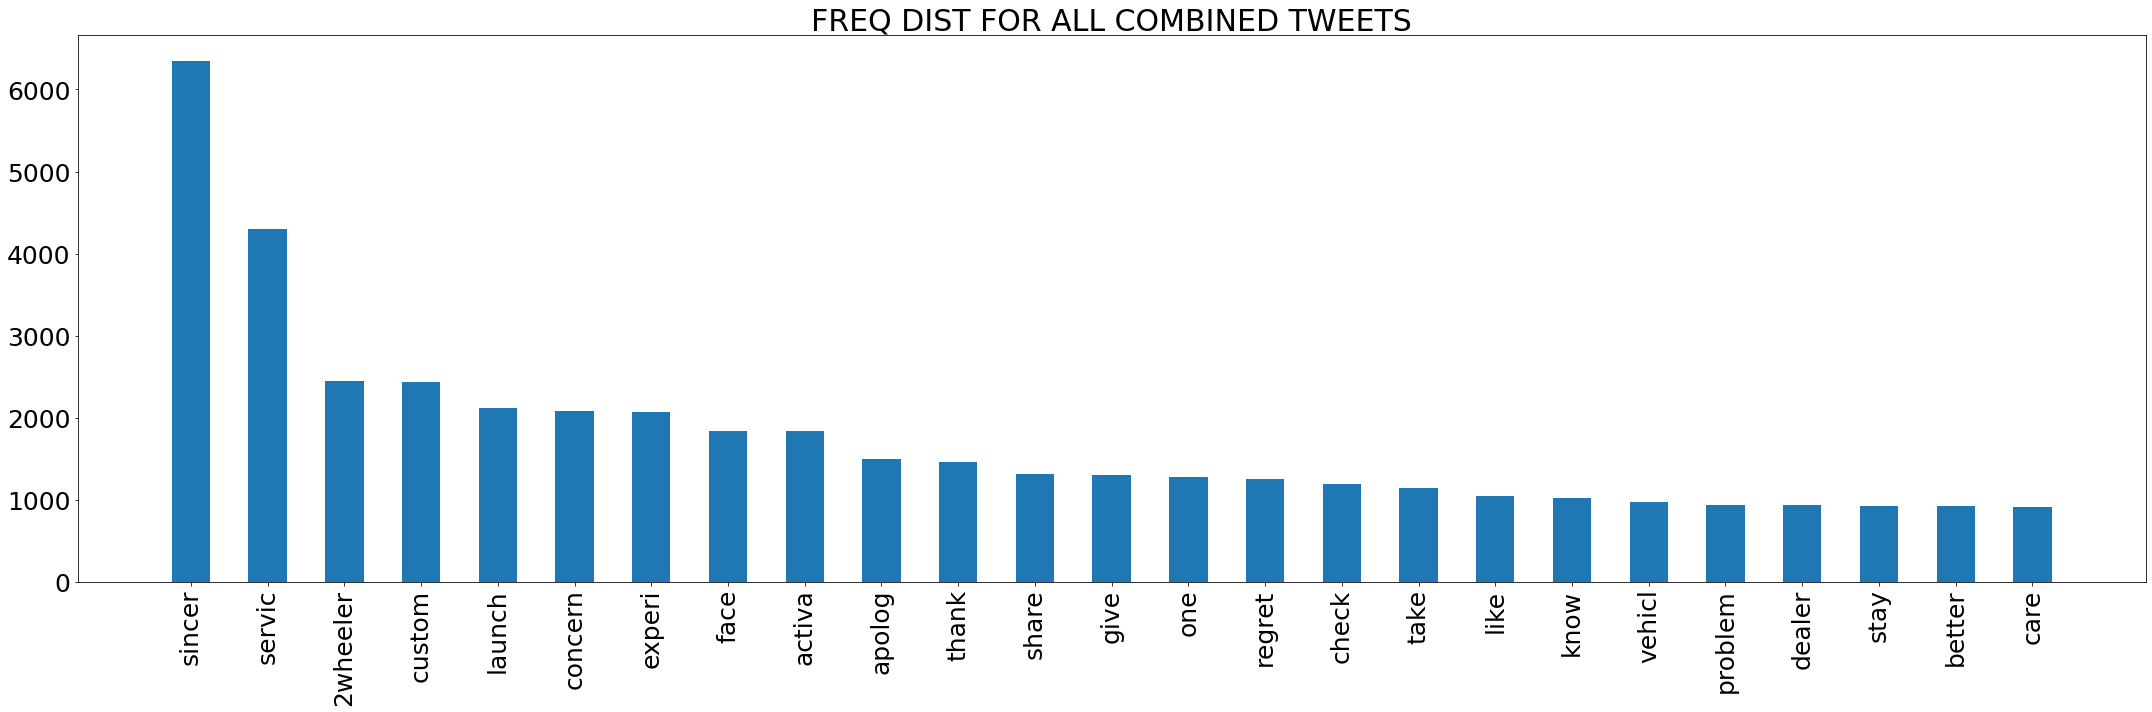

In [106]:
freqdists = get_freqdist(all_tweets)
plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][0:25],freqdists['freq'][0:25],width=0.5)
plt.title("FREQ DIST FOR ALL COMBINED TWEETS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

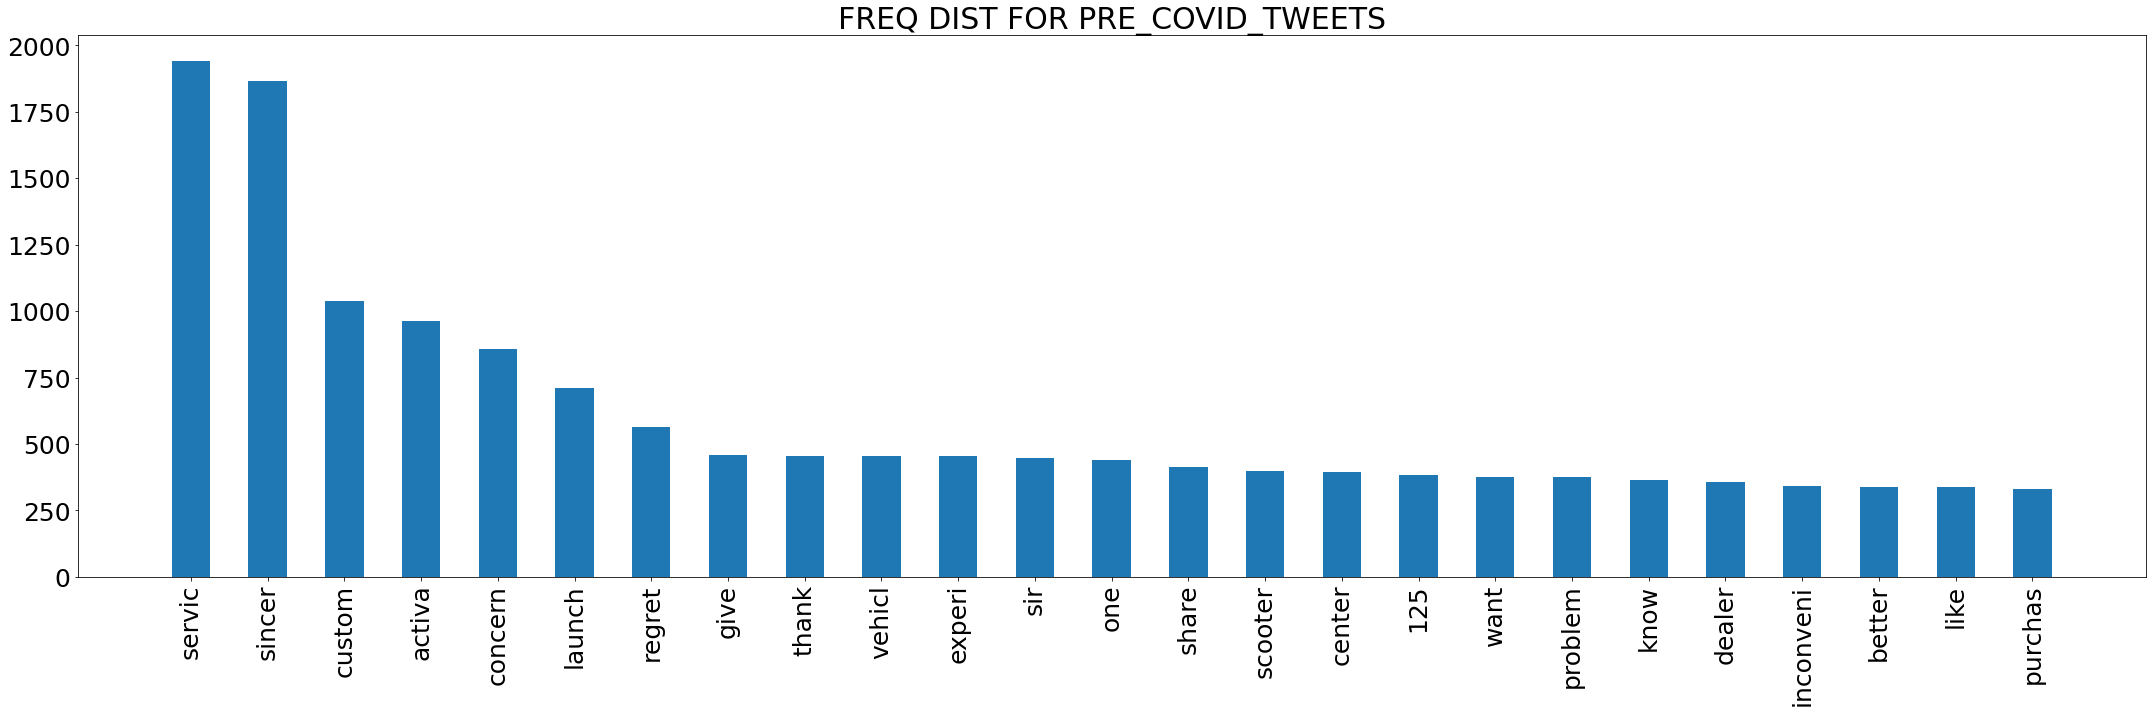

In [107]:
freqdists = get_freqdist(pre_covid_tweets)
plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][0:25],freqdists['freq'][0:25],width=0.5)
plt.title("FREQ DIST FOR PRE_COVID_TWEETS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

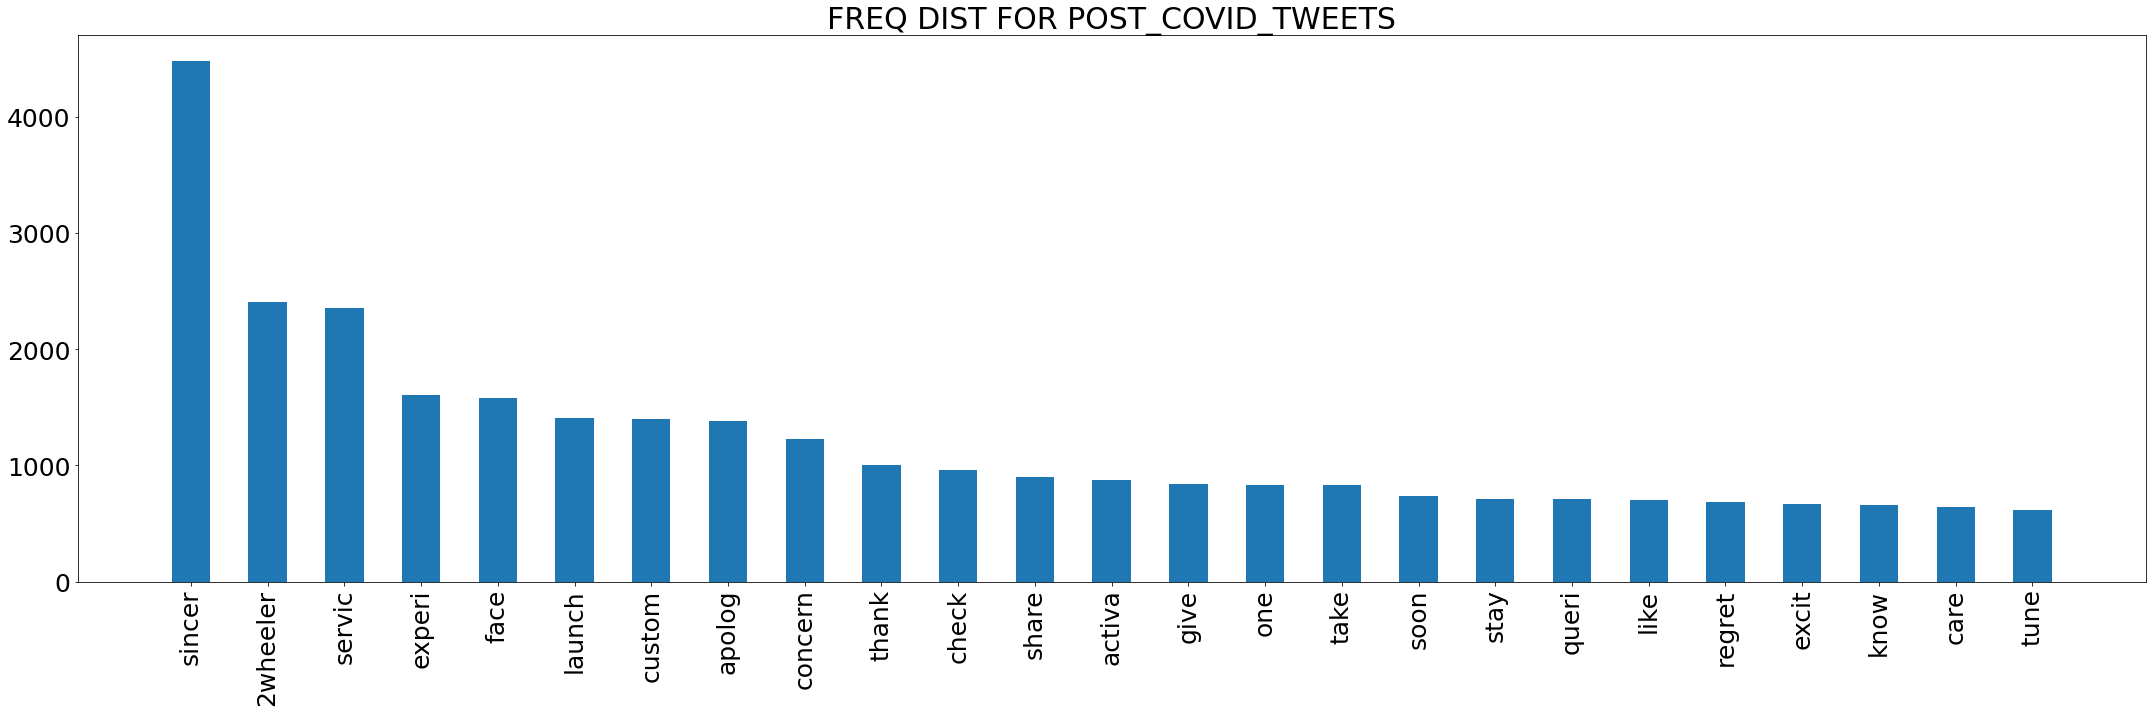

In [108]:
freqdists = get_freqdist(post_covid_tweets)
plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][0:25],freqdists['freq'][0:25],width=0.5)
plt.title("FREQ DIST FOR POST_COVID_TWEETS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [109]:
data = [[all_tweets.shape[0]],
         [pre_covid_tweets.shape[0]],
        [post_covid_tweets.shape[0]]]

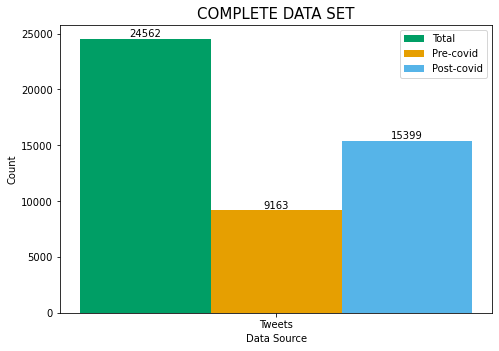

In [110]:
X = np.arange(1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = '#009E65', width = 0.25, label='Total')
ax.bar(X + 0.25, data[1], color = '#E69F01', width = 0.25, label='Pre-covid')
ax.bar(X + 0.50, data[2], color = '#56B4E8', width = 0.25, label='Post-covid')

ax.set_title('COMPLETE DATA SET',fontsize=15)
plt.xlabel('Data Source')
plt.ylabel('Count')
plt.xticks(X+0.25,['Tweets'])
plt.legend(loc="upper right")

rects = ax.patches

labels = [item for sublist in data for item in sublist] # converting list of list to a list

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

In [111]:
!pip install plotly
!pip install cufflinks

In [199]:
# References
#http://web.quant-platform.com/trial/yves/Plotly_Cufflinks.html
#https://scentellegher.github.io/programming/2017/07/15/pandas-groupby-multiple-columns-plot.html
#https://towardsdatascience.com/analysis-of-tweets-on-the-hong-kong-protest-movement-2019-with-python-a331851f061



import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [200]:
all_tweets_time = pd.concat([pre_covid_tweets,post_covid_tweets])

In [201]:
daily_count = pd.concat([all_tweets_time.groupby('Date').count()['ID']],axis=1)
daily_count.columns = ['Tweet Count']
daily_count.iplot(title='DAILY COUNT',theme='white')

In [202]:
all_tweets_time['Date']=pd.to_datetime(all_tweets_time['Date'],infer_datetime_format=True)

monthly_count = pd.concat([all_tweets_time.groupby(all_tweets_time.Date.dt.to_period("M")).count()["ID"]],axis=1)
monthly_count.columns = ['Tweet Count']
monthly_count.iplot(title='MONTHLY COUNT',theme='white')

# Tweet Hashtag Analysis

In [226]:
all_tweets_time = all_tweets_time.reset_index(drop=True) # Resetting index
split_data = all_tweets_time['Hashtags'].str.split(', ')
split_data.dropna(inplace=True)
split_data = split_data.reset_index(drop=True) # Dropping NaN values and resetting index

In [227]:
tags = []

for row in range(len(split_data)):
    tags.extend(split_data[row])
    
hashtags = [tag[1:-1] for tag in tags]

In [228]:
hashtags

['worst',
 'poor',
 'torontomotorcycleshow',
 'hondacbr1000rr',
 'hondafireblade',
 'cbr1000rrfireblade',
 'hrchonda',
 'hondamoto',
 'cbrfireblade',
 'superbikesofinstagram',
 'BWSnippet',
 'HondaAfricaTwin',
 'AfricaTwin',
 'Honda',
 'AfricaTwinStandard',
 'AfricaTwinAdventureSportES',
 'NewAfricaTwin',
 'HondaGoldWing',
 'GoldWing',
 'MardiGras',
 'GoldWingTrike',
 'CSC',
 'CaliforniaSidecar',
 'HondaTrike',
 'kannur',
 'honda',
 'Review',
 'FeaturedStories',
 'HondaUnicorn',
 'testdrive',
 'testdriveguru',
 'bike',
 'newlaunched',
 'CRF1100L',
 'AfricaTwin',
 'Honda',
 'TrustedBrand',
 'twowheeler',
 'FeaturedStories',
 'HondaUnicorn',
 'testdrive',
 'testdriveguru',
 'bike',
 'newlaunched',
 '6Changesthegame',
 'cb750',
 'cb750k',
 'cb750k4',
 'sohc4',
 'hondamotorcycles',
 'hondamotorcyle',
 'motorcycles',
 'motorcycle',
 'BWNews',
 'Unicorn',
 'honda',
 'hondabikes',
 'hondaactiva',
 'activa125',
 'India',
 'Newbikelaunch',
 'Bikes',
 'BWSnippet',
 'Honda',
 'Forza300',
 'Bikes'

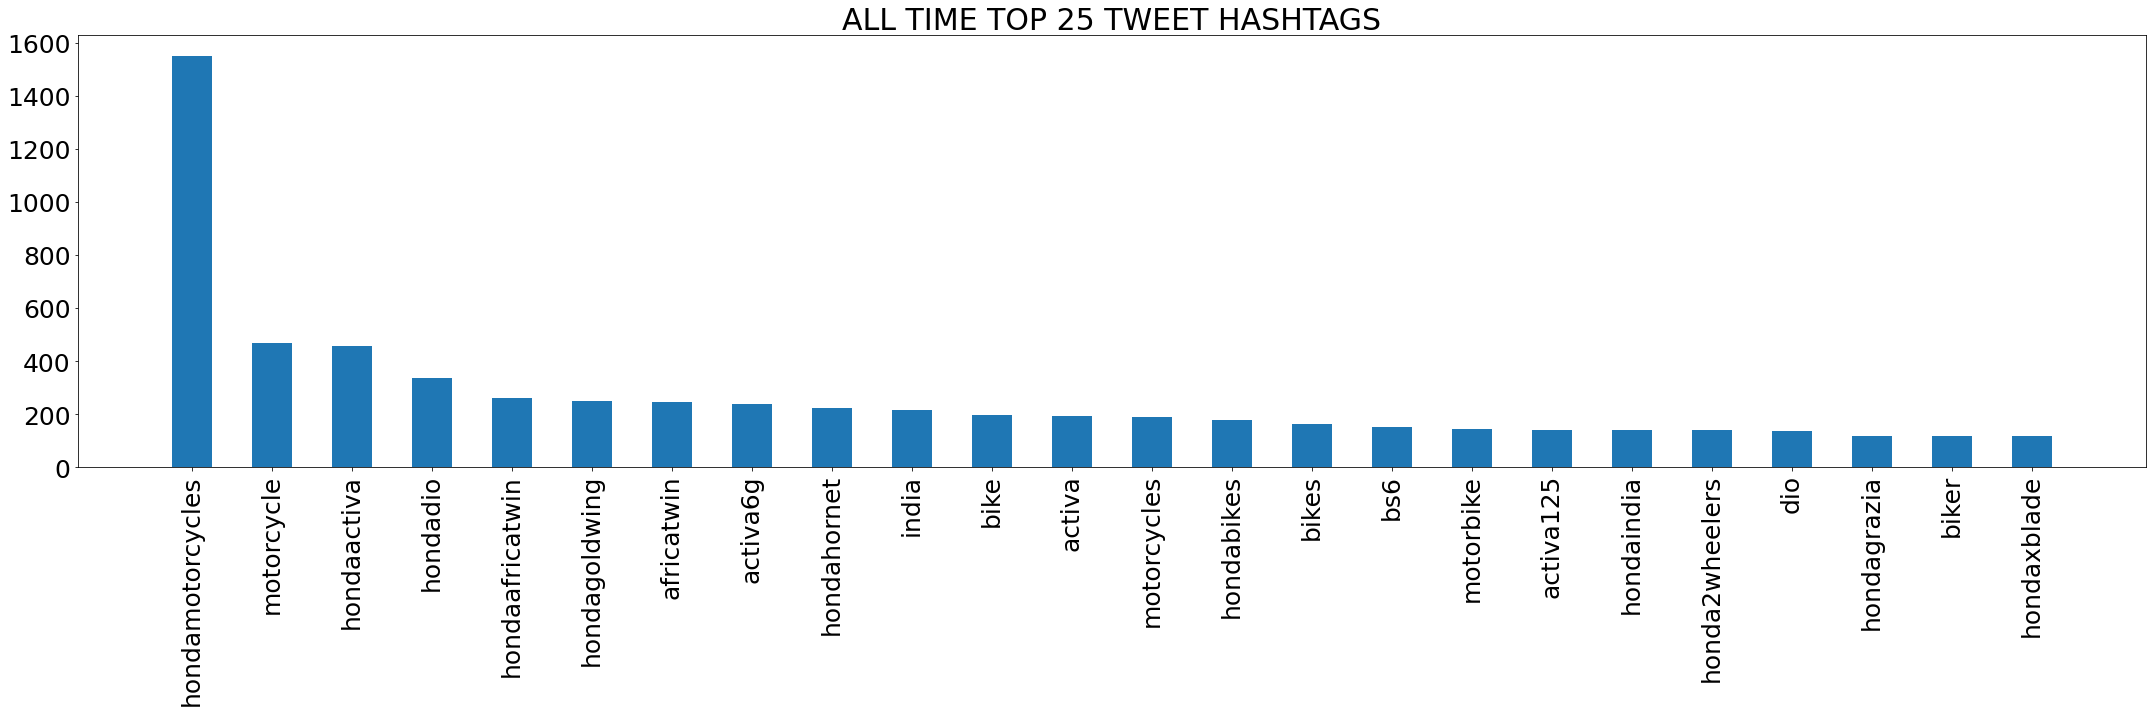

In [229]:
hashtags = [x.lower() for x in hashtags]
freqdists = pd.DataFrame(FreqDist(hashtags).items(), columns = ["words","freq"])
freqdists.sort_values(ascending=False, by="freq",inplace=True)
skipwords = ['Hondamotorcycle','motorcycle','honda','hondamotorcycles','motorcycle','honda2wheelersindia']

plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][1:25],freqdists['freq'][1:25],width=0.5) # Excluding royalenfield
plt.title("ALL TIME TOP 25 TWEET HASHTAGS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [230]:
# Popular hashtags monthwise

pop_hashtag_month = all_tweets_time[all_tweets_time['Hashtags'].notnull()].groupby(all_tweets_time.Date.dt.to_period("M")).agg({'Hashtags':lambda line: ', '.join(line)})
pop_hashtag_month = pop_hashtag_month.reset_index()

pop_hashtags = []
pop_hashtags_freq = pd.DataFrame()

for item in range(pop_hashtag_month.shape[0]):
    
    tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(1)[0] # eval removes quotes from a string
    
    if tag in ['hondamotorcycle','honda','harleydavidson','coalindia','infy','hondamotorcycles','motorcycle','honda2wheelersindia']: # filtering obvious tags
        tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(2)[1] # picking next best
        if tag in ['hondamotorcycle','honda','harleydavidson','coalindia','infy','hondamotorcycles','motorcycle','honda2wheelersindia']:
            tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(3)[2] # picking next best
        
    pop_hashtags.append([tag,count])
    
pop_hashtags_freq = pd.DataFrame(pop_hashtags,columns=['Hashtag','Count'])
pop_hashtags_freq['Date'] = pop_hashtag_month['Date']
pop_hashtags_freq = pop_hashtags_freq[['Date','Hashtag','Count']]

In [231]:
pop_hashtags_freq

,Date,Hashtag,Count
0,2019-07,honda2wheelersindia,44
1,2019-08,hondadio,22
2,2019-09,activa125,56
3,2019-10,hondaactiva,25
4,2019-11,hondasp125,33
5,2019-12,motorcycle,16
6,2020-01,activa6g,126
7,2020-02,hondaactiva,35
8,2020-03,africatwin,62
9,2020-04,hondaactiva,26


In [232]:
annotations=dict(zip([pop_hashtags_freq['Date'][n].strftime('%Y-%m') for n in range(len(pop_hashtags_freq['Date']))],pop_hashtags_freq['Hashtag']))
pop_hashtags_freq.iplot(kind='bar',x='Date',y='Count',yTitle='Count',theme='white',annotations=annotations,title='MONTHLY TWEET HASHTAG POPULARITY')

# Official Twitter Handle Analysis

###### Market Messaging (using data collected only from official twitter handle)

In [233]:
# Analysis excludes tweets from users who mentioned @royalenfield

all_off_comp_tweets_time = pd.concat([pre_covid_off_comp_tweets,post_covid_off_comp_tweets])
daily_count = all_off_comp_tweets_time.groupby('Date').count()['ID']
daily_count.columns = ['Tweet Count','Comment Count']
daily_count.iplot(title='DAILY COUNT - COMPANY',theme='white')

In [234]:
all_off_comp_tweets_time = all_off_comp_tweets_time.reset_index(drop=True) # Resetting index
split_data = all_off_comp_tweets_time['Hashtags'].str.split(', ')
split_data.dropna(inplace=True)
split_data = split_data.reset_index(drop=True) # Dropping NaN values and resetting index

In [235]:
tags = []

for row in range(len(split_data)):
    tags.extend(split_data[row])
    
hashtags = [tag[1:-1] for tag in tags]

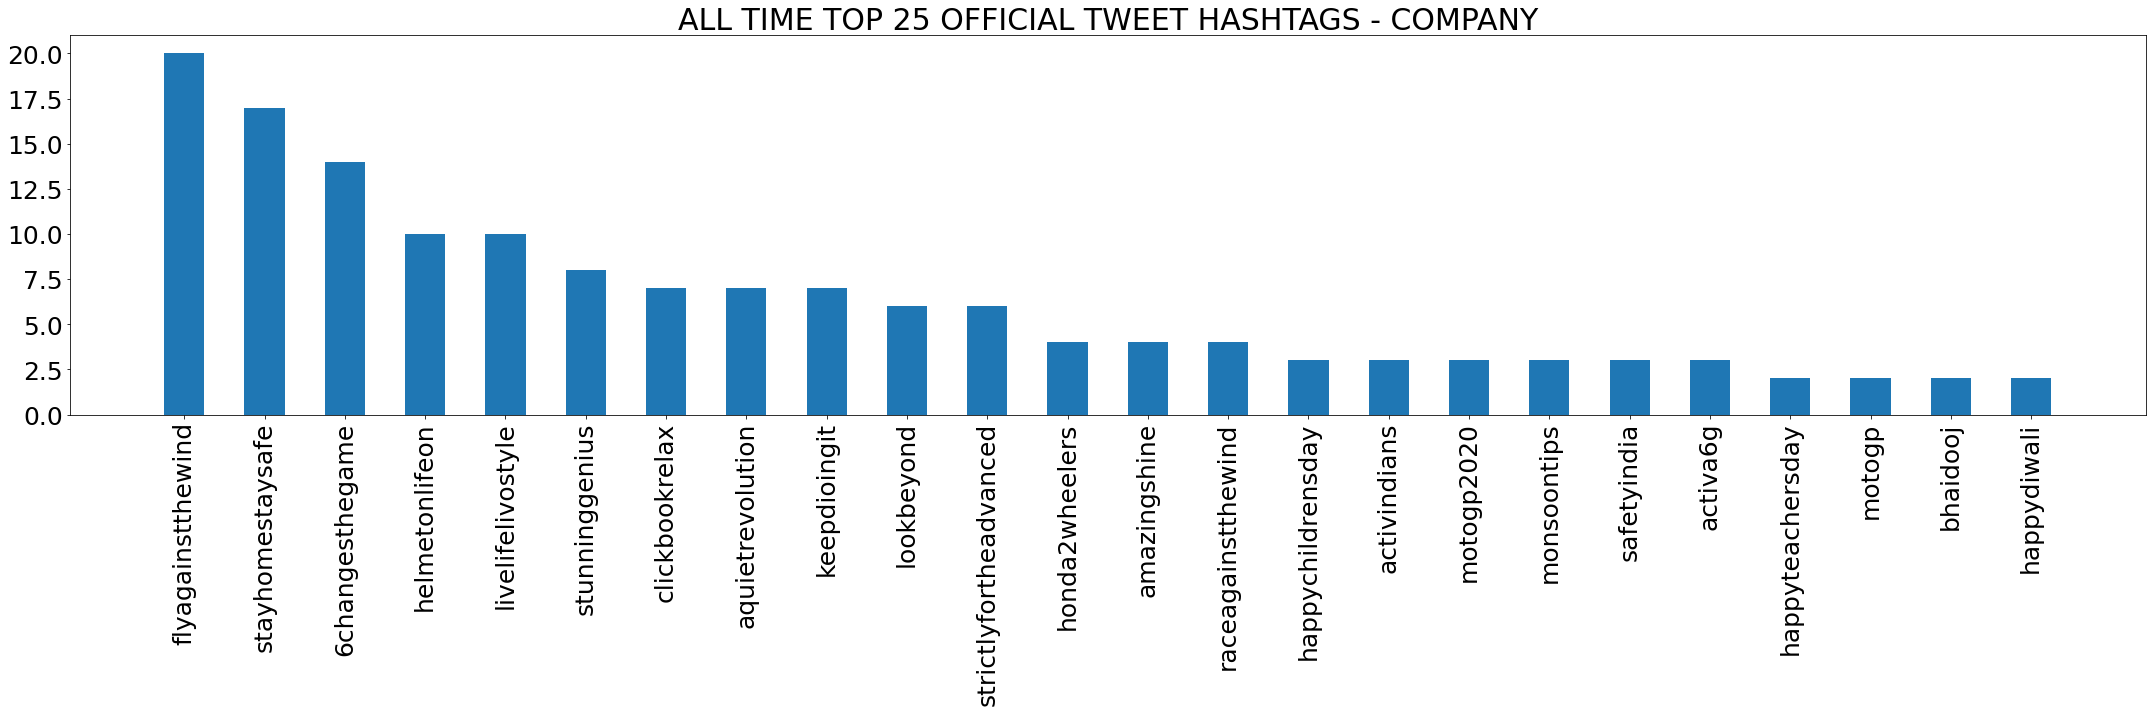

In [236]:
hashtags = [x.lower() for x in hashtags]
freqdists = pd.DataFrame(FreqDist(hashtags).items(), columns = ["words","freq"])
freqdists.sort_values(ascending=False, by="freq",inplace=True)
skipwords = ['royalenfield','motorcycle',]

plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][1:25],freqdists['freq'][1:25],width=0.5) # Excluding royalenfield
plt.title("ALL TIME TOP 25 OFFICIAL TWEET HASHTAGS - COMPANY",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [237]:
# Popular hashtags monthwise

pop_hashtag_month = all_off_comp_tweets_time[all_off_comp_tweets_time['Hashtags'].notnull()].groupby(all_off_comp_tweets_time.Date.dt.to_period("M")).agg({'Hashtags':lambda line: ', '.join(line)})
pop_hashtag_month = pop_hashtag_month.reset_index()

pop_hashtags = []
pop_hashtags_freq = pd.DataFrame()

for item in range(pop_hashtag_month.shape[0]):
    
    tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(1)[0] # eval removes quotes from a string
    
    if tag in ['royalenfield','royalenfieldindia']: # filtering obvious tags
        tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(2)[1] # picking next best
        if tag in ['royalenfield','royalenfieldindia']:
            tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(3)[2] # picking next best
        
    pop_hashtags.append([tag,count])
    
pop_hashtags_freq = pd.DataFrame(pop_hashtags,columns=['Hashtag','Count'])
pop_hashtags_freq['Date'] = pop_hashtag_month['Date']
pop_hashtags_freq = pop_hashtags_freq[['Date','Hashtag','Count']]

In [238]:
pop_hashtags_freq

,Date,Hashtag,Count
0,2019-07,monsoontips,3
1,2019-08,safetytips,2
2,2019-09,coloursofnavratri,1
3,2019-10,helmetonlifeon,2
4,2019-11,happychildrensday,3
5,2019-12,helmetonlifeon,2
6,2020-01,6changesthegame,4
7,2020-02,helmetonlifeon,2
8,2020-03,socialdistancing,1
9,2020-04,stayhomestaysafe,12


In [239]:
annotations=dict(zip([pop_hashtags_freq['Date'][n].strftime('%Y-%m') for n in range(len(pop_hashtags_freq['Date']))],pop_hashtags_freq['Hashtag']))
pop_hashtags_freq.iplot(kind='bar',x='Date',y='Count',yTitle='Count',theme='white',annotations=annotations,title='MONTHLY OFFICIAL TWEET HASHTAG POPULARITY - COMPANY')

###### user Response (using data collected only from official twitter handle)

In [240]:
# Analysis excludes tweets directly from the company

all_off_user_tweets_time = pd.concat([pre_covid_off_user_tweets,post_covid_off_user_tweets])
daily_count = all_off_user_tweets_time.groupby('Date').count()['ID']
daily_count.columns = ['Tweet Count','Comment Count']
daily_count.iplot(title='DAILY COUNT - USER',theme='white')

In [241]:
daily_count.to_excel(r'daily_count.xlsx', index = True)

In [242]:
all_off_user_tweets_time = all_off_user_tweets_time.reset_index(drop=True) # Resetting index
split_data = all_off_user_tweets_time['Hashtags'].str.split(', ')
split_data.dropna(inplace=True)
split_data = split_data.reset_index(drop=True) # Dropping NaN values and resetting index

In [243]:
tags = []

for row in range(len(split_data)):
    tags.extend(split_data[row])
    
hashtags = [tag[1:-1] for tag in tags]

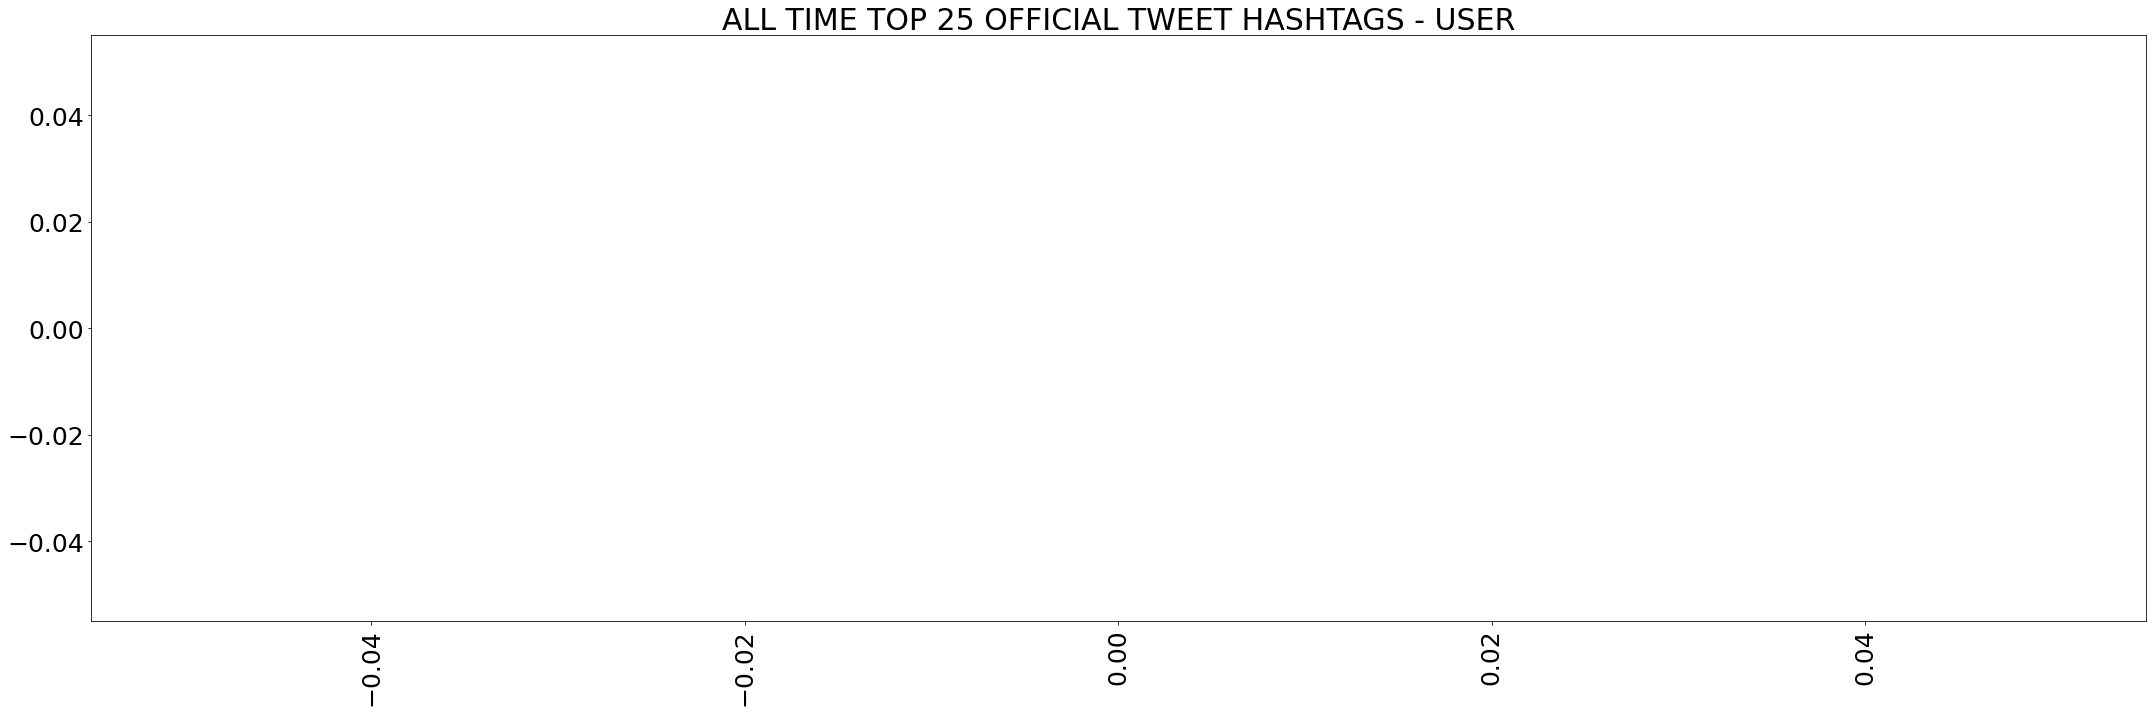

In [244]:
hashtags = [x.lower() for x in hashtags]
freqdists = pd.DataFrame(FreqDist(hashtags).items(), columns = ["words","freq"])
freqdists.sort_values(ascending=False, by="freq",inplace=True)
skipwords = ['royalenfield','motorcycle',]

plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][1:25],freqdists['freq'][1:25],width=0.5) # Excluding royalenfield
plt.title("ALL TIME TOP 25 OFFICIAL TWEET HASHTAGS - USER",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [245]:
# Popular hashtags monthwise

pop_hashtag_month = all_off_user_tweets_time[all_off_user_tweets_time['Hashtags'].notnull()].groupby(all_off_user_tweets_time.Date.dt.to_period("M")).agg({'Hashtags':lambda line: ', '.join(line)})
pop_hashtag_month = pop_hashtag_month.reset_index()

pop_hashtags = []
pop_hashtags_freq = pd.DataFrame()

for item in range(pop_hashtag_month.shape[0]):
    
    tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(1)[0] # eval removes quotes from a string
    
    '''
    
    if tag in ['royalenfield','royalenfieldindia']: # filtering obvious tags
        tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(2)[1] # picking next best
        if tag in ['royalenfield','royalenfieldindia']:
            tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(3)[2] # picking next best
        
    '''
    pop_hashtags.append([tag,count])
    
pop_hashtags_freq = pd.DataFrame(pop_hashtags,columns=['Hashtag','Count'])
pop_hashtags_freq['Date'] = pop_hashtag_month['Date']
pop_hashtags_freq = pop_hashtags_freq[['Date','Hashtag','Count']]

In [246]:
pop_hashtags_freq

,Date,Hashtag,Count


In [247]:
annotations=dict(zip([pop_hashtags_freq['Date'][n].strftime('%Y-%m') for n in range(len(pop_hashtags_freq['Date']))],pop_hashtags_freq['Hashtag']))
pop_hashtags_freq.iplot(kind='bar',x='Date',y='Count',yTitle='Count',theme='white',annotations=annotations,title='MONTHLY OFFICIAL TWEET HASHTAG POPULARITY - USER')

# Bigrams

In [248]:
def get_dtm_bigram(df):
    
    # create a bigram count vectorizer object
    bigram_count_vectorizer = CountVectorizer(ngram_range=(2,2),stop_words=stop_updated,max_features=150)
    X_bigram = bigram_count_vectorizer.fit_transform(df['Cleaned_text'])
    # Creating a DTM
    DTM_bigram = pd.DataFrame(X_bigram.toarray(), columns=bigram_count_vectorizer.get_feature_names())
    return DTM_bigram

C:\Users\DALVENDRA\1\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'care', 'center', 'custom', 'customer', 'itchi', 'service', 'twowheeler', 'wheeer'] not in stop_words.



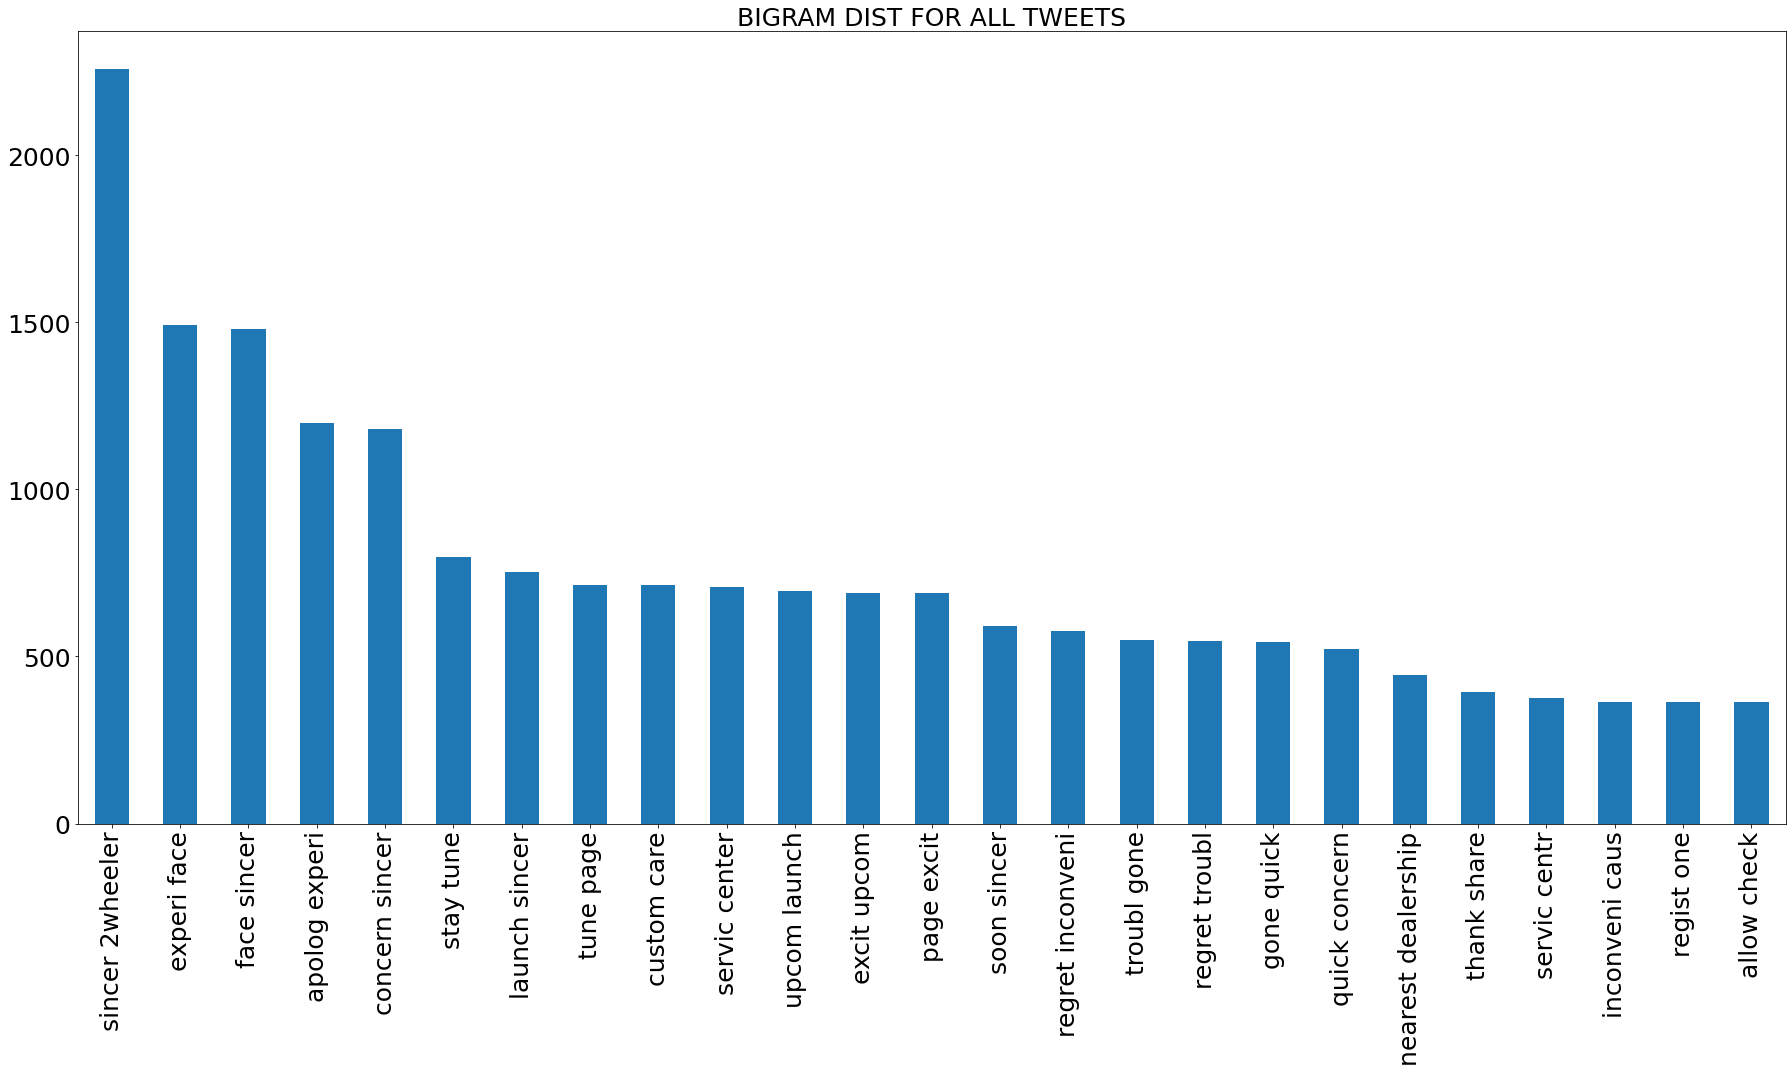

In [249]:
bigrams = get_dtm_bigram(all_tweets)
plt.figure(figsize=(25,15))
bigrams.sum().sort_values(ascending=False).head(25).plot.bar()  
plt.title("BIGRAM DIST FOR ALL TWEETS",fontsize=25)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

C:\Users\DALVENDRA\1\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'care', 'center', 'custom', 'customer', 'itchi', 'service', 'twowheeler', 'wheeer'] not in stop_words.

C:\Users\DALVENDRA\1\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'care', 'center', 'custom', 'customer', 'itchi', 'service', 'twowheeler', 'wheeer'] not in stop_words.



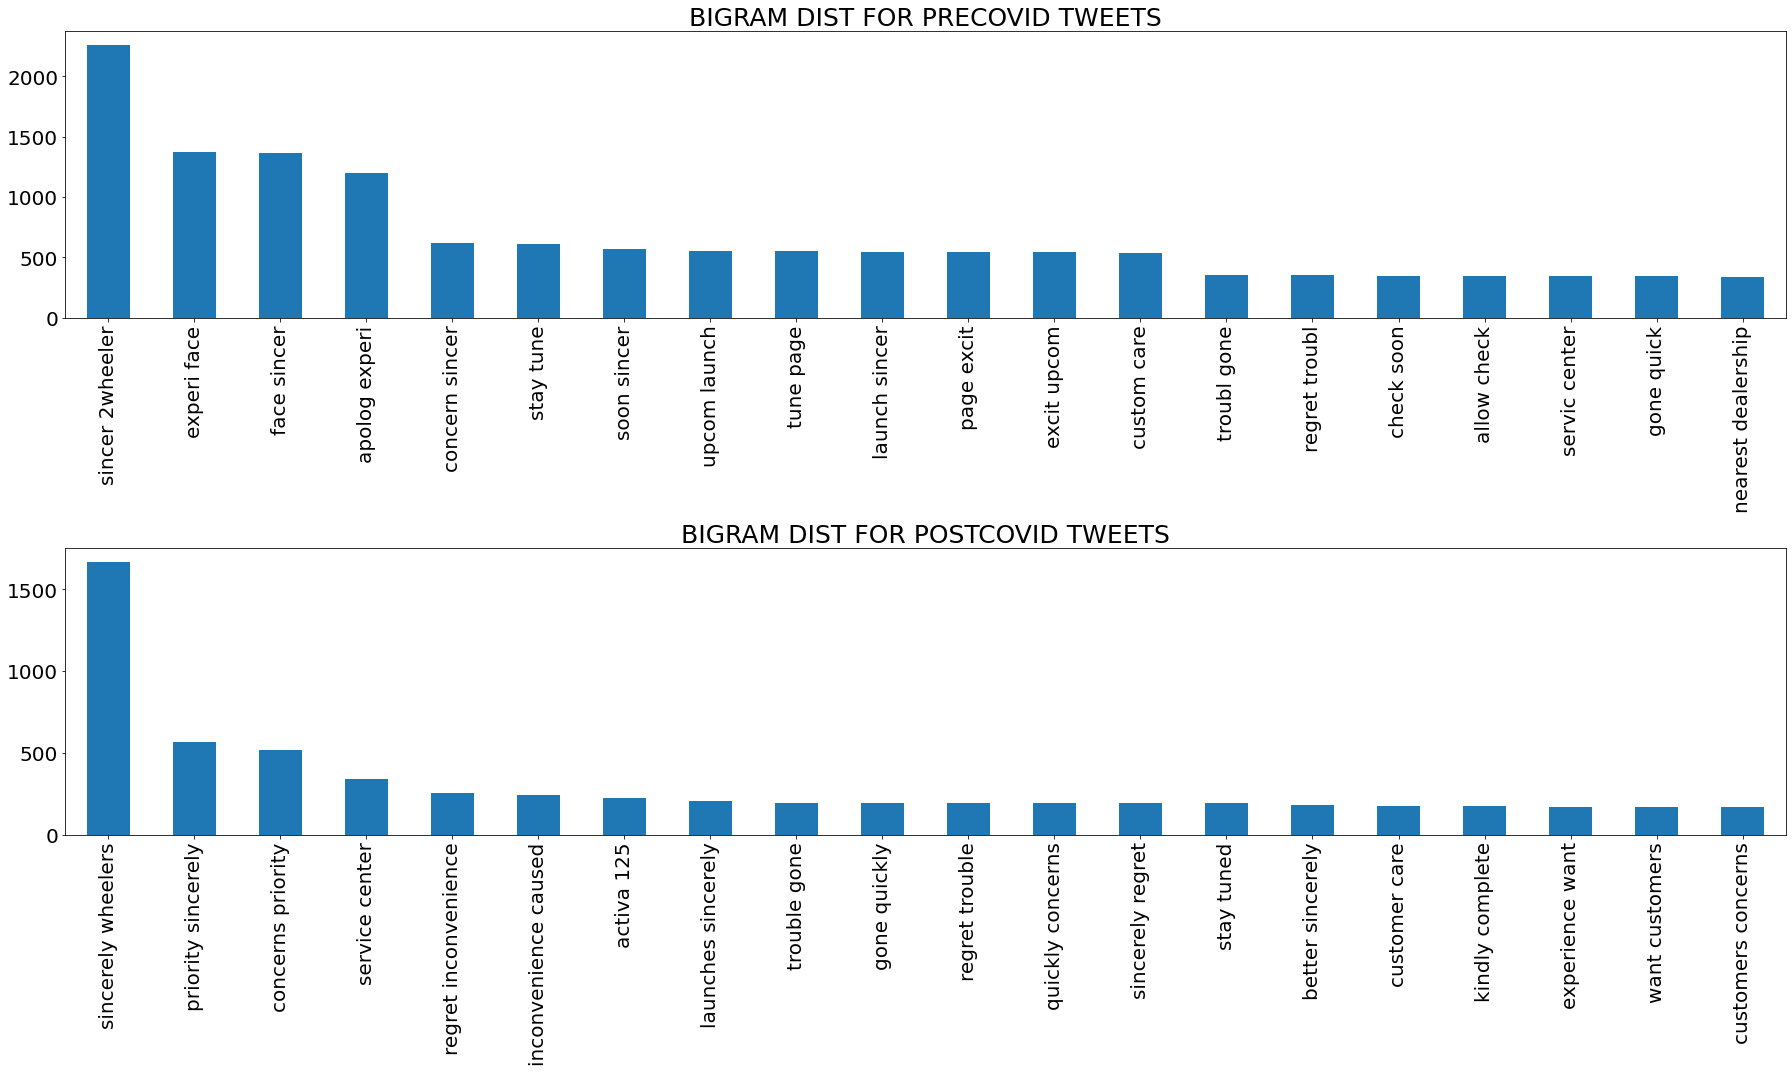

In [250]:
bigrams = [get_dtm_bigram(post_covid_tweets),get_dtm_bigram(pre_covid_tweets)]
fig,axes = plt.subplots(2,1,figsize=(25,15))

for i in range(len(bigrams)):    
    
    bigrams[i].sum().sort_values(ascending=False).head(20).plot.bar(ax=axes[i])  
    axes[i].set_title("BIGRAM DIST FOR "+periods[i].upper()+" TWEETS",fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    
plt.tight_layout()    
plt.show()

# Sentiment Analysis using VADER

In [251]:
#VADER (lexicon and rule-based sentiment analysis library)
#nltk.download('vader_lexicon')

'''
NOTE: Analysing the sentiment of the youtube comments using a rule-based approach can be extremely inaccurate 
in identifying the REAL sentiment as the sentiment score can be related to the bike or the user who uploaded the video. 
On the other hand, analysing the sentiment of the tweets can lead to relatively better interpretations.
'''
#SOURCES
# https://towardsdatascience.com/analysis-of-tweets-on-the-hong-kong-protest-movement-2019-with-python-a331851f061
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/analyze-tweet-sentiment-in-python/

'\nNOTE: Analysing the sentiment of the youtube comments using a rule-based approach can be extremely inaccurate \nin identifying the REAL sentiment as the sentiment score can be related to the bike or the user who uploaded the video. \nOn the other hand, analysing the sentiment of the tweets can lead to relatively better interpretations.\n'

In [252]:
def get_sentiment_vader(df):
    senti = SentimentIntensityAnalyzer()
    senti_score = [senti.polarity_scores(tweet)['compound'] for tweet in df['Cleaned_text']]
    return senti_score

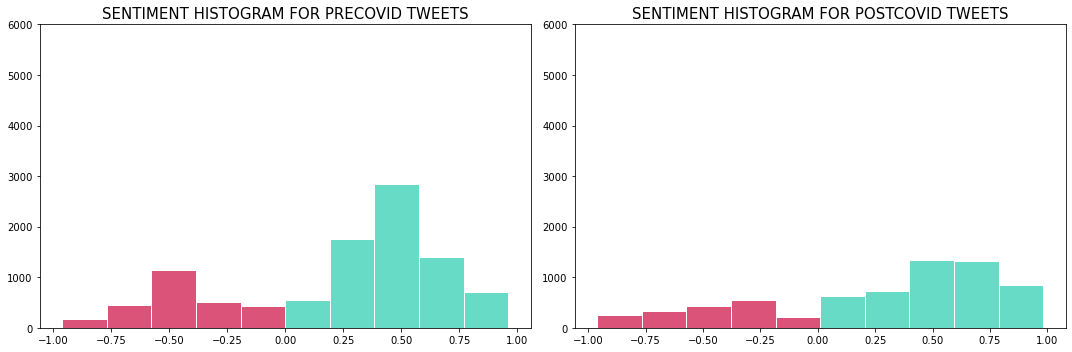

In [253]:
hists = [get_sentiment_vader(post_covid_tweets),get_sentiment_vader(pre_covid_tweets)]
fig,axes = plt.subplots(1,2,figsize=(15,5))

for i in range(len(hists)):
    
    # removing the neutral polarity values (values between 0.05 and -0.05)
    n,bins,patches=axes[i].hist([i for i in hists[i] if i >= 0.05 or i<=-0.05],facecolor='#67dbc6',edgecolor='white',linewidth=1)
    for p in patches[:5]:
        p.set_facecolor('#db5378')
    axes[i].set_title("SENTIMENT HISTOGRAM FOR "+periods[i].upper()+" TWEETS",fontsize=15)
    axes[i].set_ylim([0,6000])

plt.tight_layout()
plt.show()

In [254]:
# Percentage of zero polairty tweets ignored in the histogram

print(f"Percent of zero polarity pre covid tweets: {round(100*len([i for i in hists[0] if i == 0])/pre_covid_tweets.shape[0],0)}")
print(f"Percent of zero polarity post covid tweets: {round(100*len([i for i in hists[1] if i == 0])/post_covid_tweets.shape[0],0)}")

Percent of zero polarity pre covid tweets: 58.0
Percent of zero polarity post covid tweets: 16.0


In [255]:
# Categorizing sentiment scores and adding the category to a column

def get_sentiment(df):
    
    senti_scores = get_sentiment_vader(df)
    df["Sentiment"]= ["Very Positive" if x>=0.5 else "Positive" if x<0.5 and x>=0.05 else "Negative" if x<=-0.05 and x>-0.5 else "Very Negative" if x<=-0.5 else "Neutral" for x in senti_scores]
    return df

In [256]:
get_sentiment(pre_covid_tweets)

,ID,Date,Tweet_text,Hashtags,Usermentions,Cleaned_text,Sentiment
1561,1233339100666585088,2020-02-28,@BigWingIndia @honda2wheelerin What will be th...,NaN,BigWingIndia,expected sales figure year units bring xre 190...,Neutral
1556,1233317730557845504,2020-02-28,@honda2wheelerin I have had a very bad experie...,"'worst', 'poor'",honda2wheelerin,experience service use big name sales service ...,Negative
1584,1233203719602225152,2020-02-28,@honda2wheelerin writing to you since December...,NaN,honda2wheelerin,writing since december everytime replying conc...,Very Positive
1583,1233342781088681984,2020-02-28,@honda2wheelerin No spare part available in pu...,NaN,honda2wheelerin,spare part available pune showroom bs6 shine s...,Neutral
1582,1233346764444319744,2020-02-28,@honda2wheelerin @Shivani95625196 It seems lik...,NaN,honda2wheelerin,seems like auto msg getting months see attachm...,Very Positive
...,...,...,...,...,...,...,...
579,1145784676151250944,2019-07-01,Summer evenings in maximum attack mode. #honda...,"'hondamotorcycles', 'cb1000bigone', 'custombik...",NaN,summer evenings maximum attack mode cotswolds ...,Very Positive
9589,1145739419577487360,2019-07-01,@honda2wheelerin I didn't accepted this cheap ...,NaN,honda2wheelerin,accepted cheap service,Positive
9606,1145739097824083968,2019-07-01,@honda2wheelerin what a cheap service are you ...,NaN,honda2wheelerin,cheap service providing customers whenever cal...,Negative
9605,1145738132123340800,2019-07-01,@honda2wheelerin I had booked the honda CBR250...,NaN,honda2wheelerin,booked cbr250 red abs version 1st may showroom...,Neutral


In [257]:
get_sentiment(post_covid_tweets)

,ID,Date,Tweet_text,Hashtags,Usermentions,Cleaned_text,Sentiment
2420,1339806726745309184,2020-12-18,@honda2wheelerin Still no update. What the hel...,NaN,honda2wheelerin,still updat hell go done 3rd class dealer mont...,Very Negative
2387,1339911868383592448,2020-12-18,"@iSubhomoy31 Hello, \nStay tuned to our page f...",NaN,iSubhomoy31,stay tune page updat excit upcom launch sincer...,Neutral
2384,1339911304769761280,2020-12-18,"@ASHOKBHOGAL3 Hi Ashok, \nPlease allow us some...",NaN,ASHOKBHOGAL3,ashok allow check updat soon sincer 2wheeler,Positive
2383,1339909157240012800,2020-12-18,"@GodhwaniYash Hello, \nWe are glad your query ...",NaN,GodhwaniYash,glad queri resolv alway queri sincer wheeler,Positive
2382,1339963796425744384,2020-12-18,"@honda2wheelerin as an owner of Honda Activa, ...",NaN,honda2wheelerin,owner activa may know servic interv year old a...,Neutral
...,...,...,...,...,...,...,...
1645,1234132763525165056,2020-03-01,Yes it is the new #HondaActiva 6G. You guessed...,"'HondaActiva', 'MotorBeam'",NaN,yes guess right come much await featur,Positive
16156,1234018294337765376,2020-03-01,@honda2wheelerin @honda2wheelers \n\nWorst Exp...,'Pethtic',honda2wheelerin,worst experi even get vehicl deliveri vehicl d...,Very Negative
16154,1234049757590409216,2020-03-01,Congratulations and wish you a safe riding exp...,"'kannur', 'honda', 'kerala', 'india'",cannanorehonda,congratul wish safe ride experi sale 902045405...,Very Positive
16153,1234150934219051008,2020-03-01,Unprofessional and Rude behavior of Yug Honda ...,NaN,honda2wheelerin,unprofession rude behavior yug wakad branch ma...,Very Negative


In [258]:
# Rejoining the dataframes to include sentiment

all_tweets_time = pd.concat([pre_covid_tweets,post_covid_tweets])


# Sentiment Variation over Time

In [259]:
all_tweets_time = all_tweets_time[['Date','Sentiment']]
all_tweets_time.sort_values(ascending=False, by="Date",inplace=True)

# Creating a dummy column for count
all_tweets_time['ID'] = range(0,len(all_tweets_time))

all_tweets_time.groupby(['Date','Sentiment']).count()['ID'].unstack().iplot(colors=['#de7a95','#DBCF64','#67DBC6','#DB5378','#43a896'],
                                                                           title='TWEETS SENTIMENT VARIATION',
                                                                           yTitle='Count',
                                                                           theme='white')

In [260]:
all_tweets_time.to_excel(r'all_tweets_time.xlsx', index = True)

# Sentiment Count Plots

In [261]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DALVENDRA\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [262]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
senti = SentimentIntensityAnalyzer() 

In [263]:
def get_sentiment_vader(df):
    senti = SentimentIntensityAnalyzer()
    senti_score = [senti.polarity_scores(tweet)['compound'] for tweet in df['Cleaned_text']]
    return senti_score

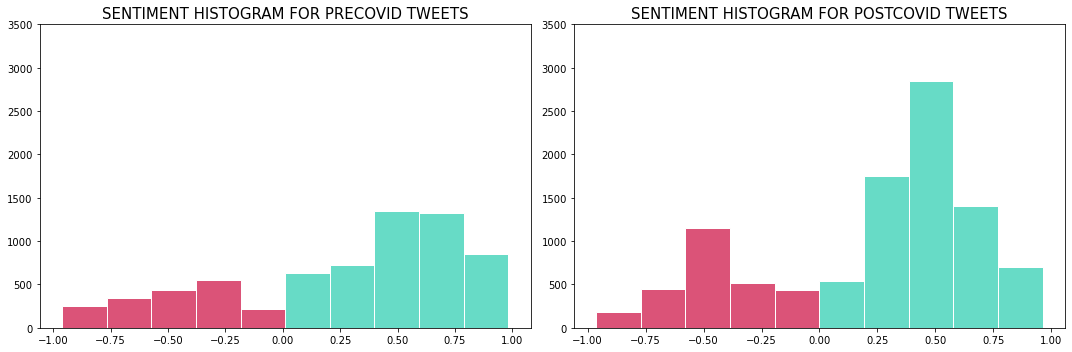

In [264]:
hists = [get_sentiment_vader(pre_covid_tweets),get_sentiment_vader(post_covid_tweets)]
fig,axes = plt.subplots(1,2,figsize=(15,5))

for i in range(len(hists)):
    
    # removing the neutral polarity values (values between 0.05 and -0.05)
    n,bins,patches=axes[i].hist([i for i in hists[i] if i >= 0.05 or i<=-0.05],facecolor='#67dbc6',edgecolor='white',linewidth=1)
    for p in patches[:5]:
        p.set_facecolor('#db5378')
    axes[i].set_title("SENTIMENT HISTOGRAM FOR "+periods[i].upper()+" TWEETS",fontsize=15)
    axes[i].set_ylim([0,3500])

plt.tight_layout()
plt.show()

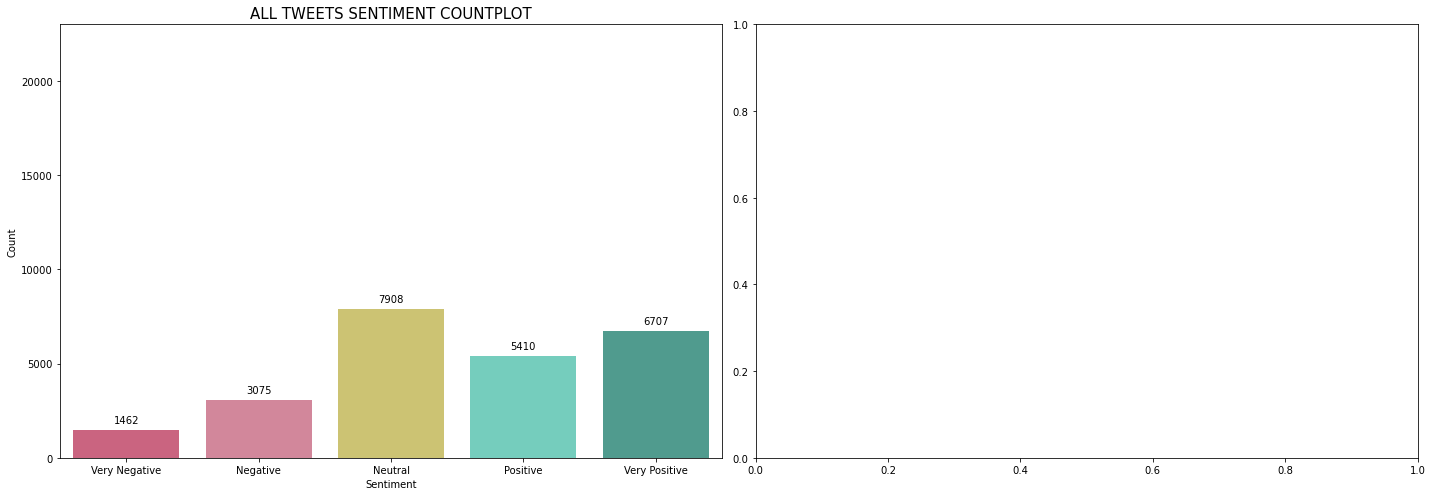

In [265]:
cplots = [all_tweets_time['Sentiment']]

titles = ["TWEETS"]

fig,axes = plt.subplots(1,2,figsize=(20,7))

for i in range(len(cplots)):

    ax = sns.countplot(cplots[i],order=['Very Negative','Negative','Neutral','Positive','Very Positive'],
                                palette=['#DB5378','#de7a95','#DBCF64','#67DBC6','#43a896'],ax=axes[i])
    axes[i].set_title('ALL '+titles[i]+' SENTIMENT COUNTPLOT',fontsize=15)
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Count')
    axes[i].set_ylim([0,23000])

    for p in ax.patches:
        ax.annotate(format(p.get_height(), 'd'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

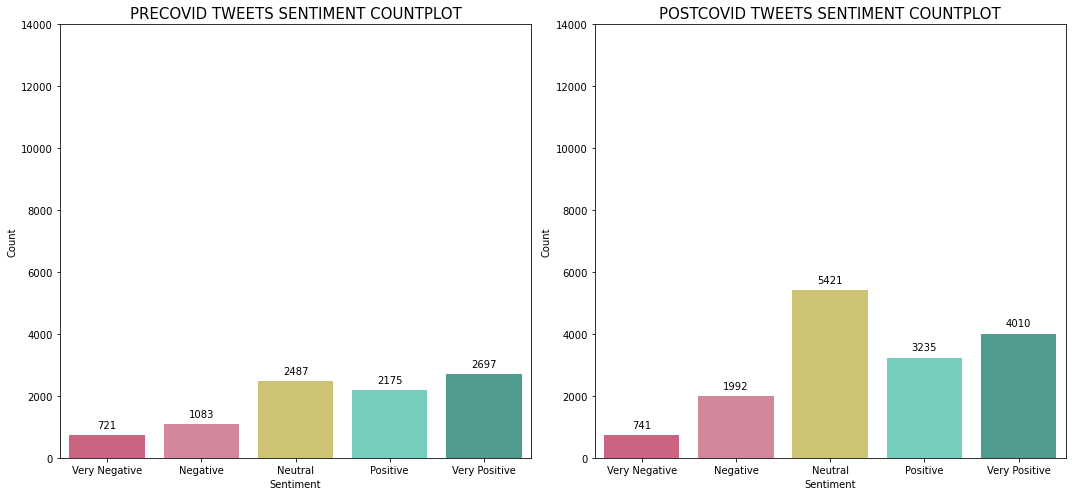

In [266]:
cplots = [pre_covid_tweets['Sentiment'],post_covid_tweets['Sentiment']]

fig,axes = plt.subplots(1,2,figsize=(15,7))

for i in range(len(cplots)):

    ax = sns.countplot(cplots[i],order=['Very Negative','Negative','Neutral','Positive','Very Positive'],
                                palette=['#DB5378','#de7a95','#DBCF64','#67DBC6','#43a896'],ax=axes[i])
    axes[i].set_title(periods[i].upper()+' TWEETS SENTIMENT COUNTPLOT',fontsize=15)
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Count')
    axes[i].set_ylim([0,14000])

    for p in ax.patches:
        ax.annotate(format(p.get_height(), 'd'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Sentiment Pie Charts

In [267]:
pre_covid_tweet_distr = pre_covid_tweets.Sentiment.value_counts(normalize=True)
pre_covid_tweet_distr

Very Positive    0.294336
Neutral          0.271418
Positive         0.237368
Negative         0.118193
Very Negative    0.078686
Name: Sentiment, dtype: float64

In [268]:
post_covid_tweet_distr = post_covid_tweets.Sentiment.value_counts(normalize=True)
post_covid_tweet_distr

Neutral          0.352036
Very Positive    0.260407
Positive         0.210079
Negative         0.129359
Very Negative    0.048120
Name: Sentiment, dtype: float64

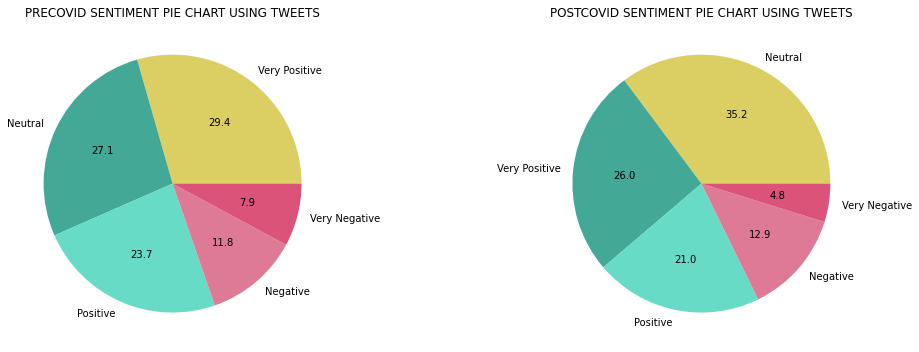

In [269]:
distr = [pre_covid_tweet_distr,post_covid_tweet_distr]
fig,axes = plt.subplots(1,2,figsize=(15,5)); #axes.axis("equal")

for i in range(len(distr)):
    
    axes[i].pie(distr[i].values,labels=list(distr[i].keys()),autopct='%1.1f',colors=['#DBCF64','#43a896','#67DBC6','#de7a95','#DB5378'])
    axes[i].title.set_text(periods[i].upper()+" SENTIMENT PIE CHART USING TWEETS")
    
plt.tight_layout()
plt.show()

# Frequency Distributions based on Sentiment

In [270]:
neg_dist_tweets = get_freqdist(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]))
pos_dist_tweets = get_freqdist(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]))

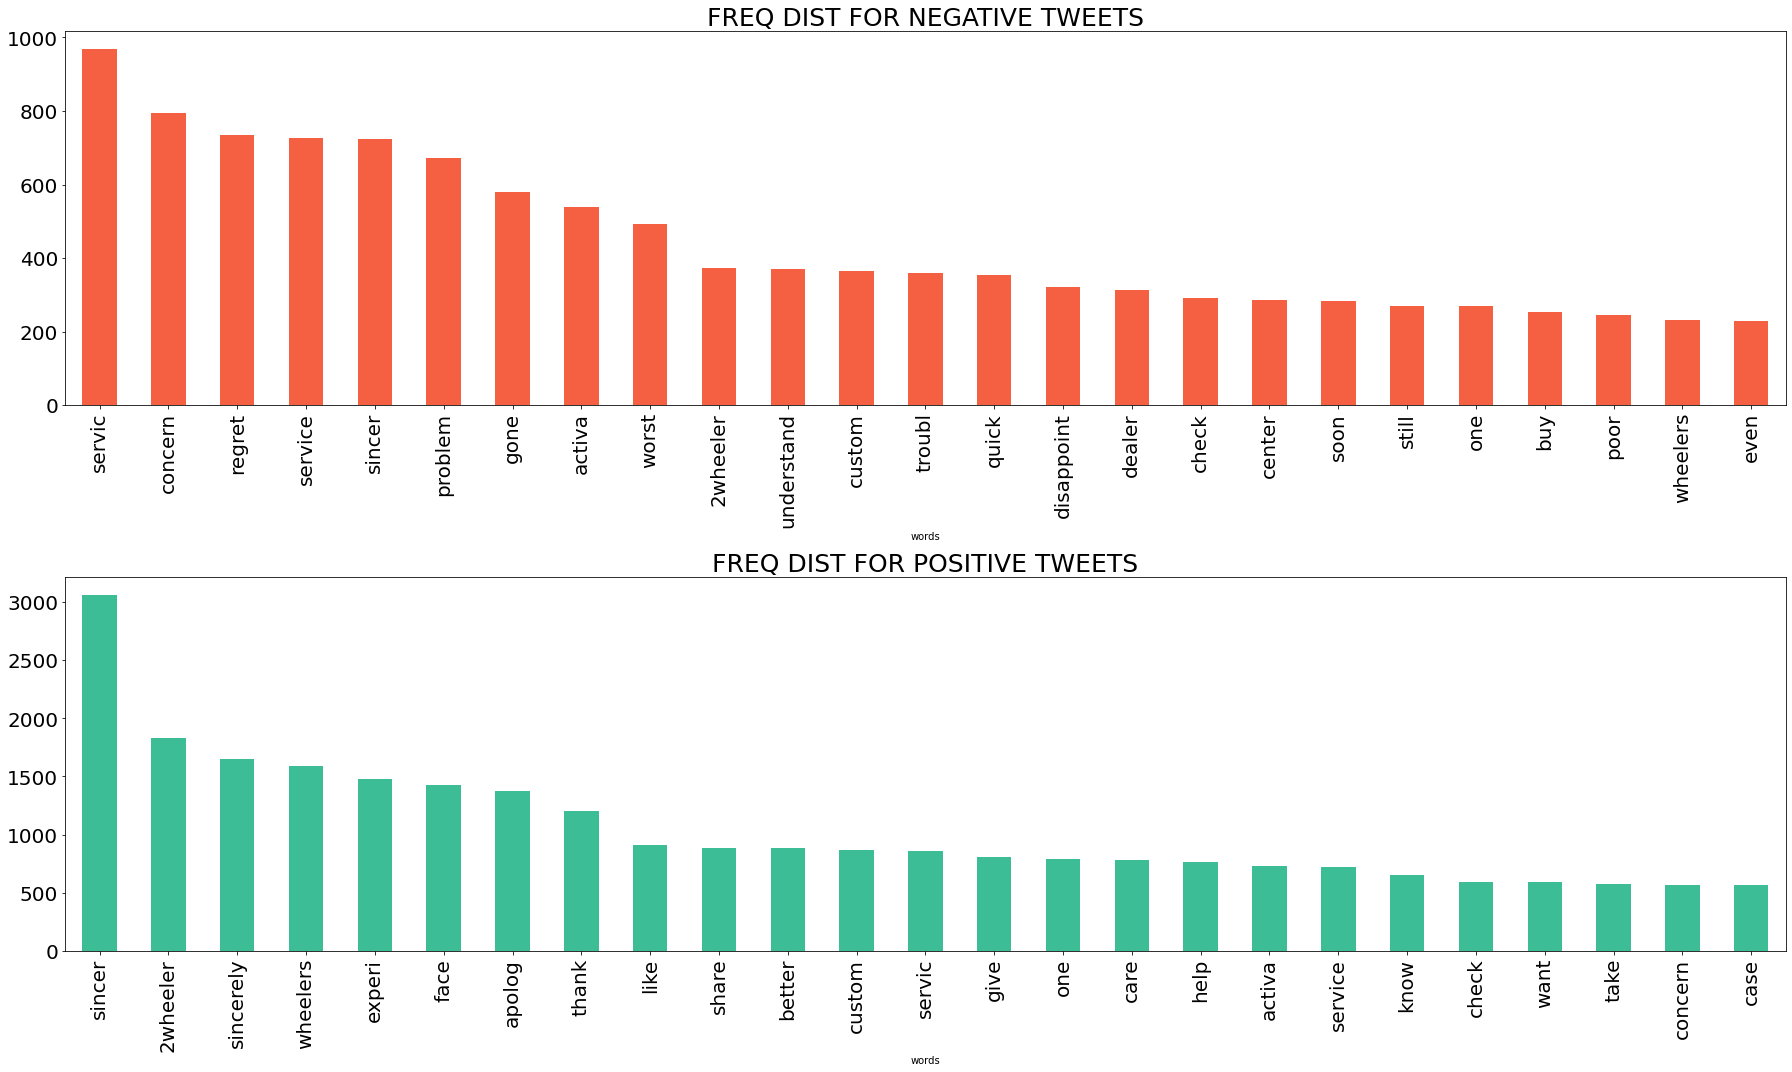

In [271]:
freqdists = [neg_dist_tweets,pos_dist_tweets]
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
fig,axes = plt.subplots(2,1,figsize=(25,15))
for i in range(len(freqdists)):
    freqdists[i].head(25).plot.bar(x='words',y='freq',ax=axes[i],color=colors[i])
    axes[i].set_title("FREQ DIST FOR "+names[i]+" TWEETS",fontsize=25)
    #axes[i].set_xlabel('',fontsize=20)
    #axes[i].set_ylabel('Count',fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

# Bigrams based on Sentiment

In [272]:
neg_big_tweets = get_dtm_bigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]))
pos_big_tweets = get_dtm_bigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]))

C:\Users\DALVENDRA\1\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'care', 'center', 'custom', 'customer', 'itchi', 'service', 'twowheeler', 'wheeer'] not in stop_words.

C:\Users\DALVENDRA\1\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'care', 'center', 'custom', 'customer', 'itchi', 'service', 'twowheeler', 'wheeer'] not in stop_words.



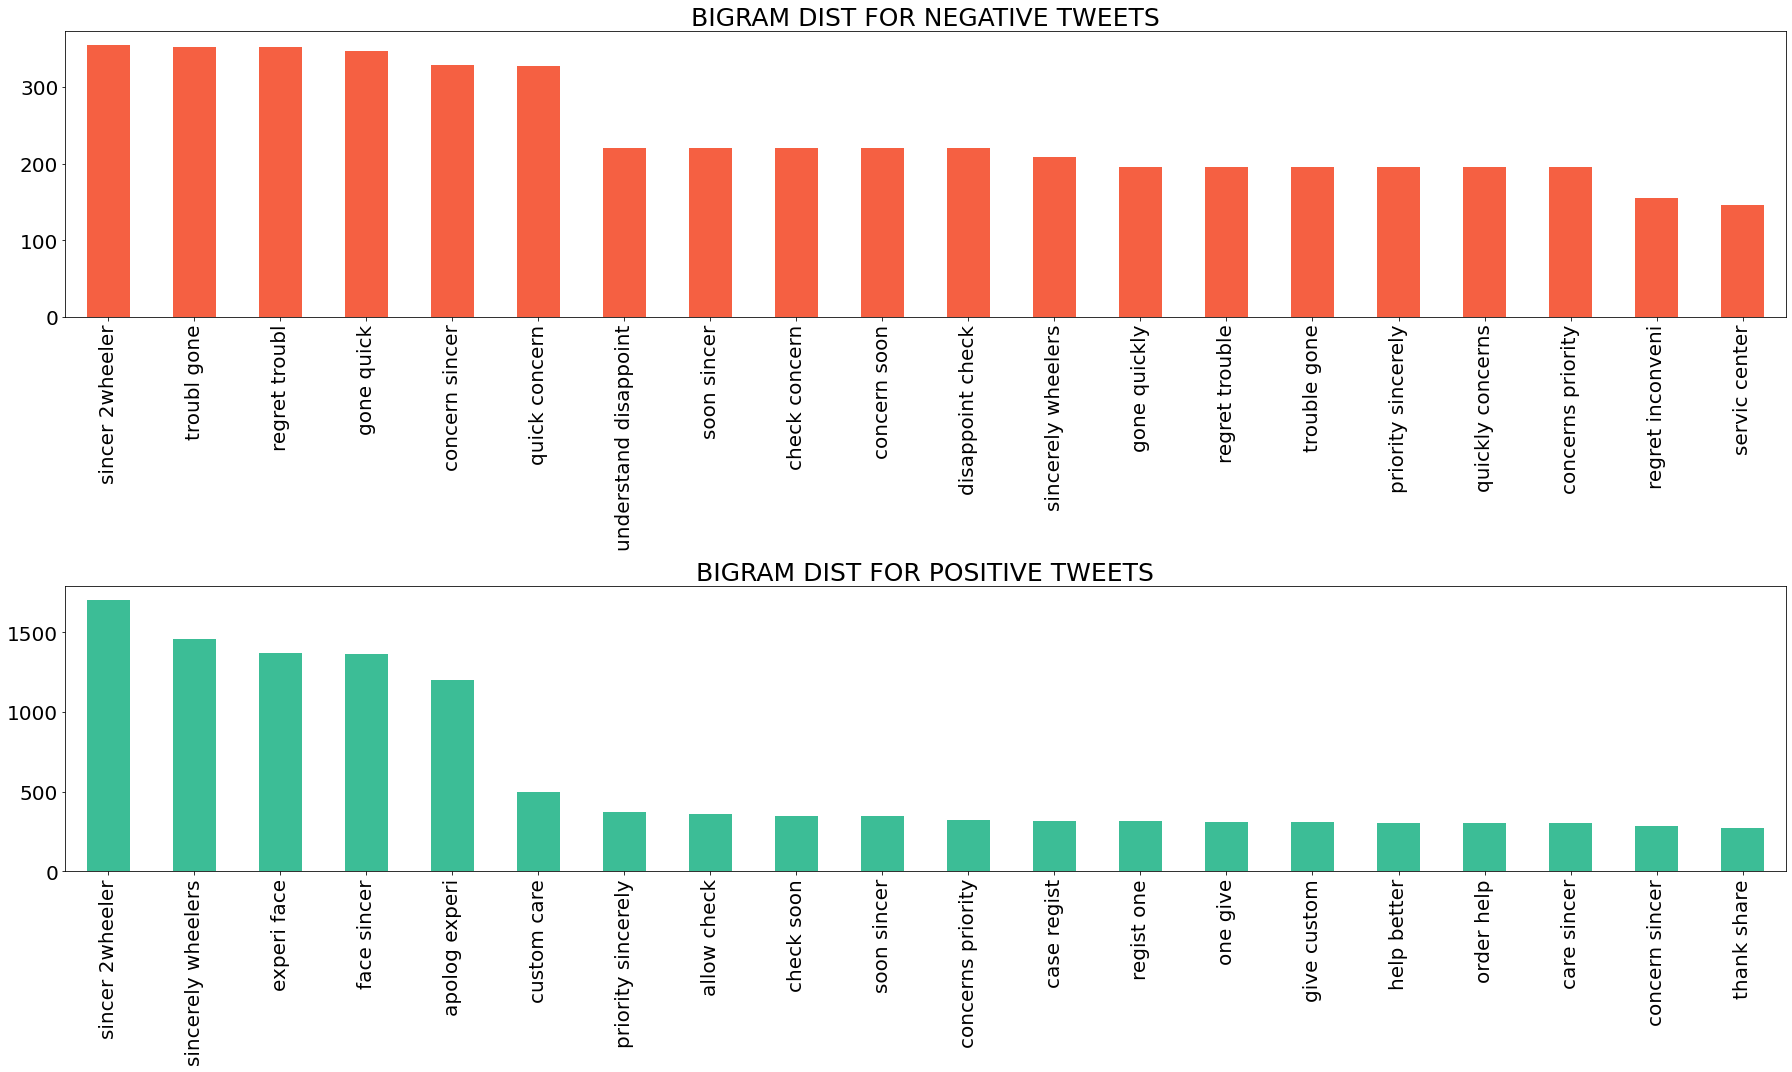

In [273]:
bigrams = [neg_big_tweets,pos_big_tweets]
fig,axes = plt.subplots(2,1,figsize=(25,15))
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
for i in range(len(bigrams)):    
    
    bigrams[i].sum().sort_values(ascending=False).head(20).plot.bar(ax=axes[i],color=colors[i])  
    axes[i].set_title("BIGRAM DIST FOR "+names[i]+" TWEETS",fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    
plt.tight_layout()    
plt.show()

# Trigrams based on Sentiment

In [274]:
def get_dtm_trigram(df):
    
    # create a trigram count vectorizer object
    trigram_count_vectorizer = CountVectorizer(ngram_range=(3,3),stop_words=stop_updated,max_features=150)
    X_trigram = trigram_count_vectorizer.fit_transform(df['Cleaned_text'])
    # Creating a DTM
    DTM_trigram = pd.DataFrame(X_trigram.toarray(), columns=trigram_count_vectorizer.get_feature_names())
    return DTM_trigram

In [275]:
neg_tri_tweets = get_dtm_trigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]))
pos_tri_tweets = get_dtm_trigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]))

C:\Users\DALVENDRA\1\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'care', 'center', 'custom', 'customer', 'itchi', 'service', 'twowheeler', 'wheeer'] not in stop_words.

C:\Users\DALVENDRA\1\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'care', 'center', 'custom', 'customer', 'itchi', 'service', 'twowheeler', 'wheeer'] not in stop_words.



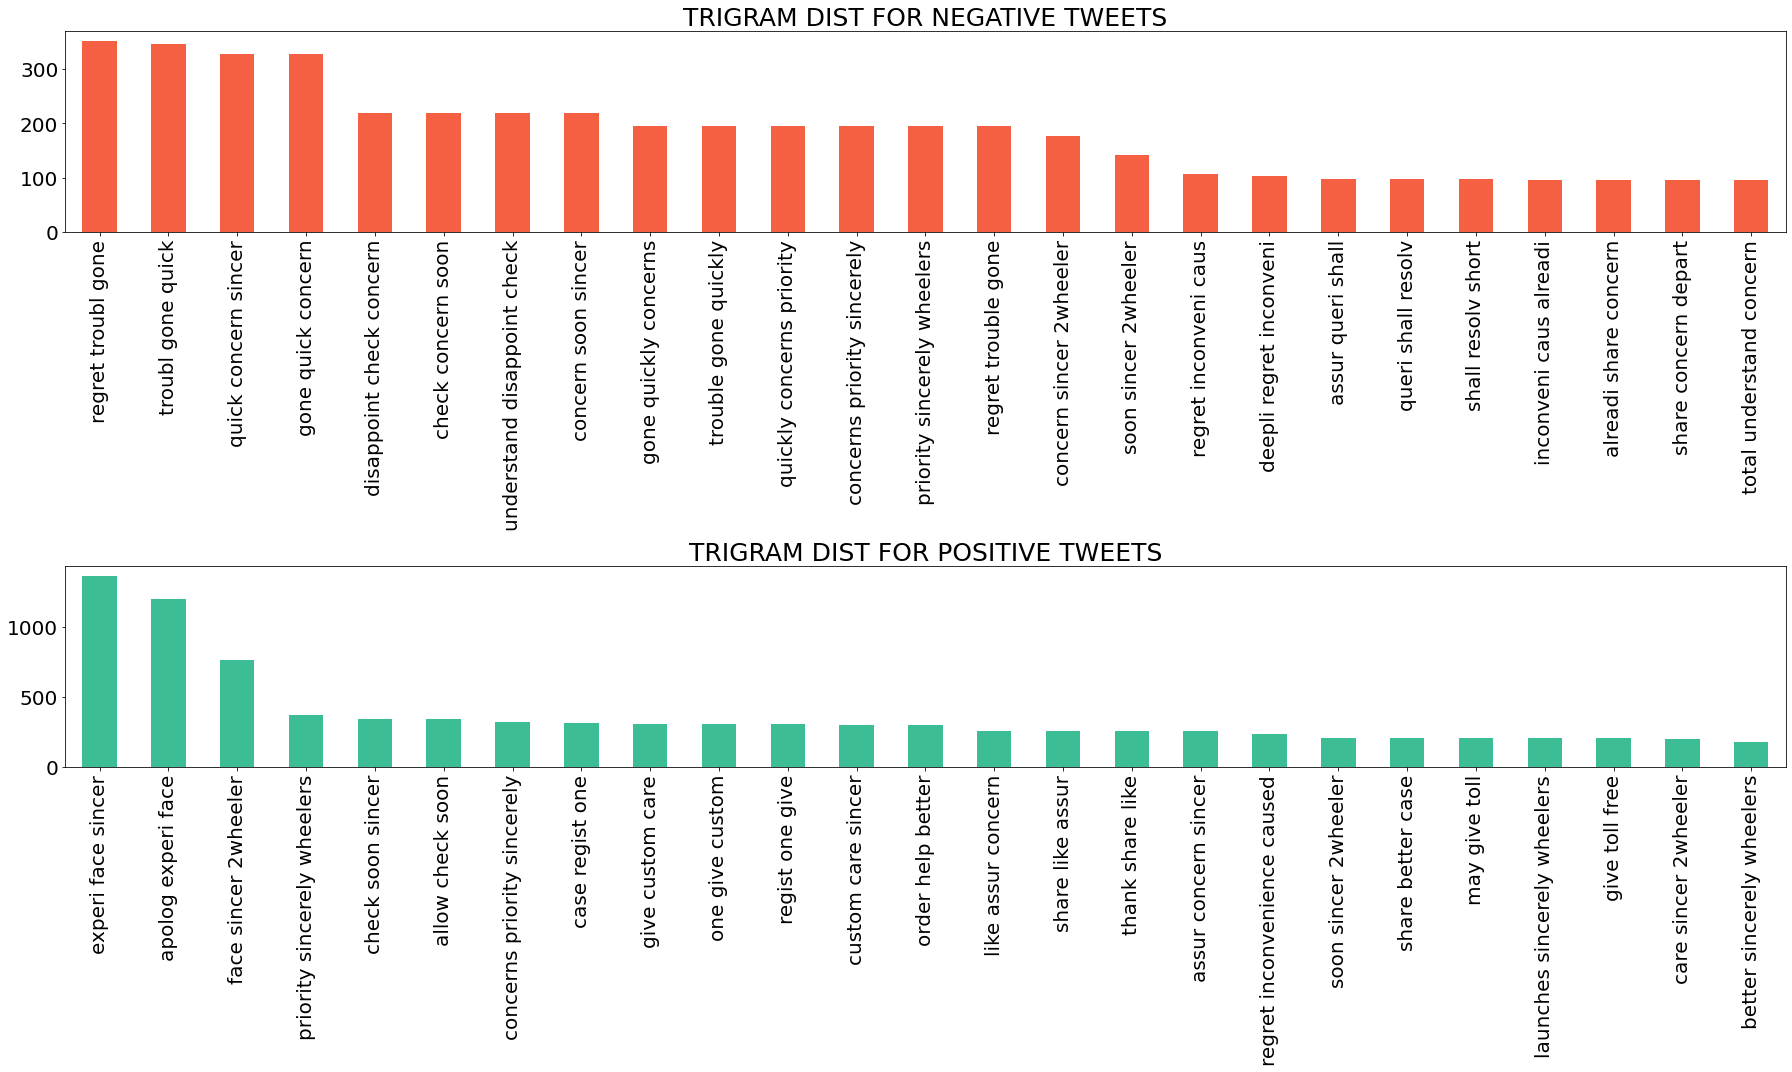

In [276]:
trigrams = [neg_tri_tweets,pos_tri_tweets]
fig,axes = plt.subplots(2,1,figsize=(25,15))
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
for i in range(len(trigrams)):    
    
    trigrams[i].sum().sort_values(ascending=False).head(25).plot.bar(ax=axes[i],color=colors[i])  
    axes[i].set_title("TRIGRAM DIST FOR "+names[i]+" TWEETS",fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    
plt.tight_layout()    
plt.show()

# Selecting most important keywords

###### Noun Frequency Distribution using NLTK POS Tagging

In [277]:
def get_freqdist_pos(df,tag):
    
    comb_comments = " ".join(df['Cleaned_text'].values)
    all_terms = word_tokenize(comb_comments)
    tagged = nltk.pos_tag([x for x in all_terms if x not in stop_updated]) # Removing stop words
    result = [(w1,t1) for (w1, t1) in tagged if t1 == tag]    
    tag_fd = nltk.FreqDist(word for (word, tag) in result)
    df_dist = pd.DataFrame(tag_fd.items(), columns = ["words","freq"])
    df_dist.sort_values(ascending=False, by="freq",inplace=True)
    
    return df_dist

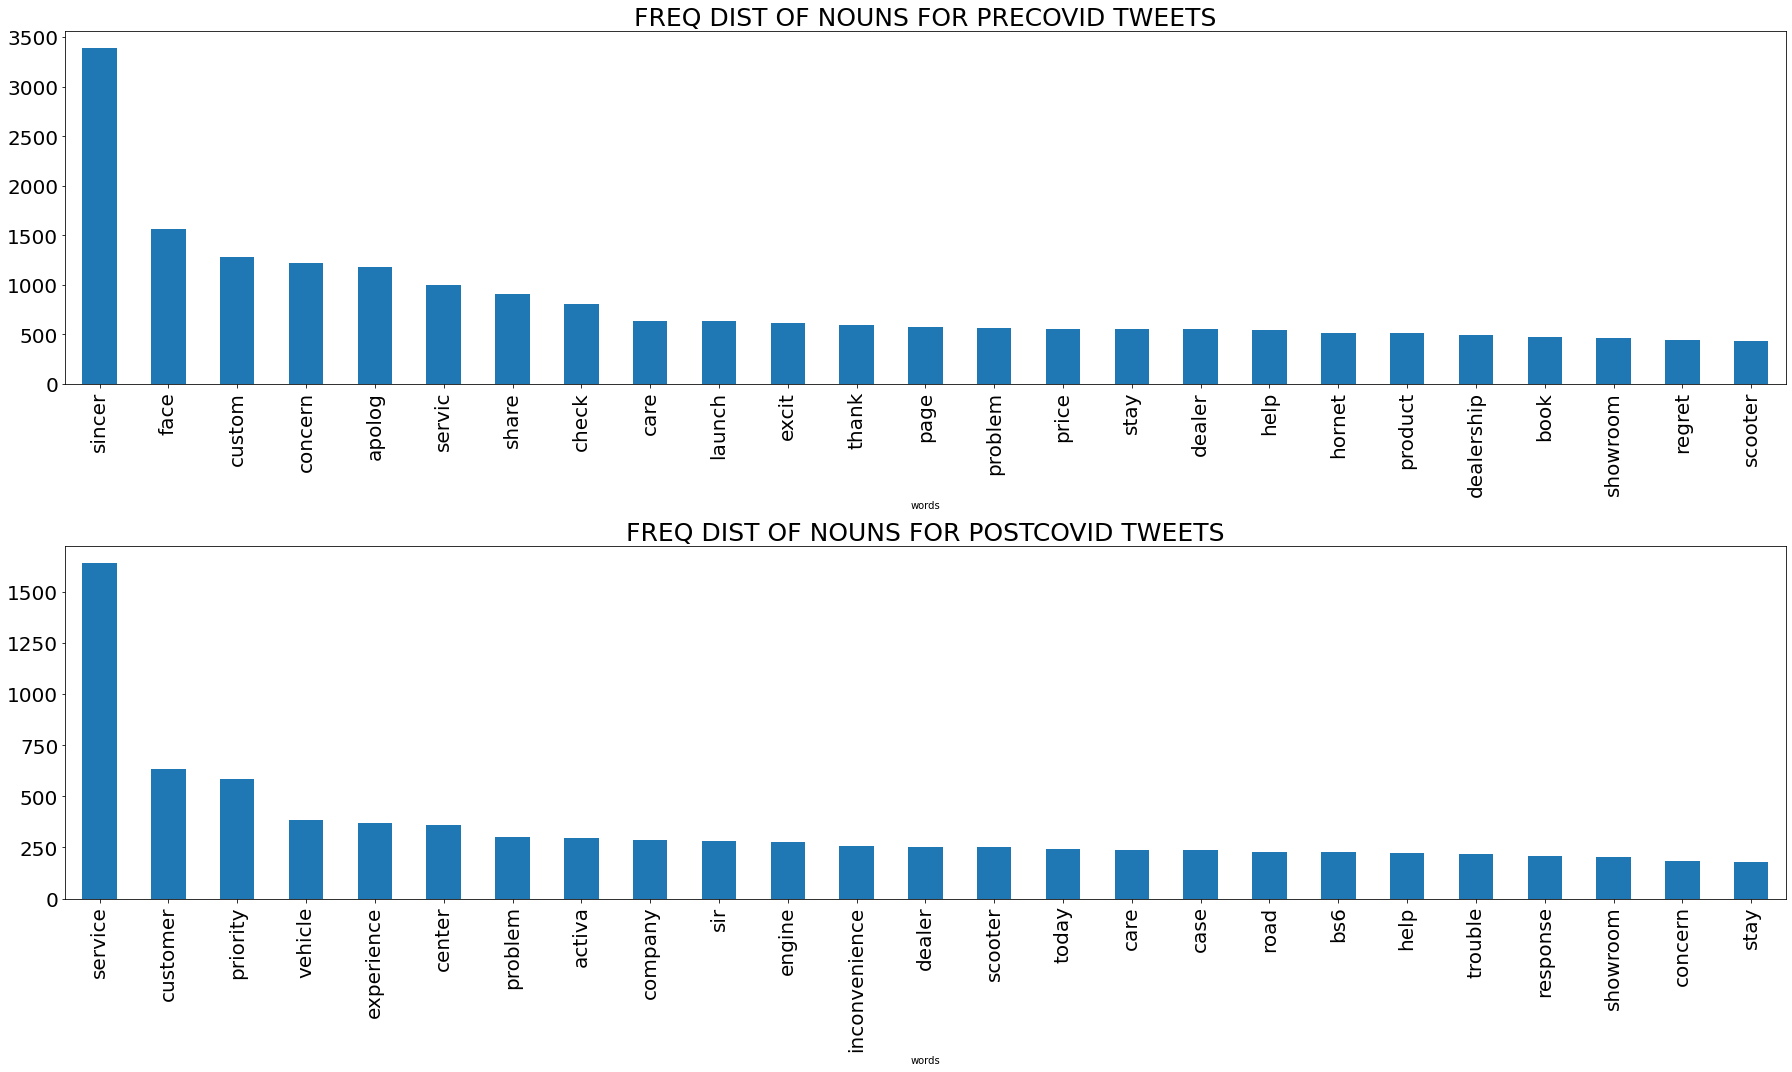

In [278]:
freqdists = [get_freqdist_pos(post_covid_tweets,"NN"),get_freqdist_pos(pre_covid_tweets,"NN")]
fig,axes = plt.subplots(2,1,figsize=(25,15))
for i in range(len(freqdists)):
    freqdists[i].head(25).plot.bar(x='words',y='freq',ax=axes[i])
    axes[i].set_title("FREQ DIST OF NOUNS FOR "+periods[i].upper()+" TWEETS",fontsize=25)
    #axes[i].set_xlabel('',fontsize=20)
    #axes[i].set_ylabel('Count',fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

In [279]:
neg_dist_tweets_pos = get_freqdist_pos(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]),"NN")
pos_dist_tweets_pos = get_freqdist_pos(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]),"NN")

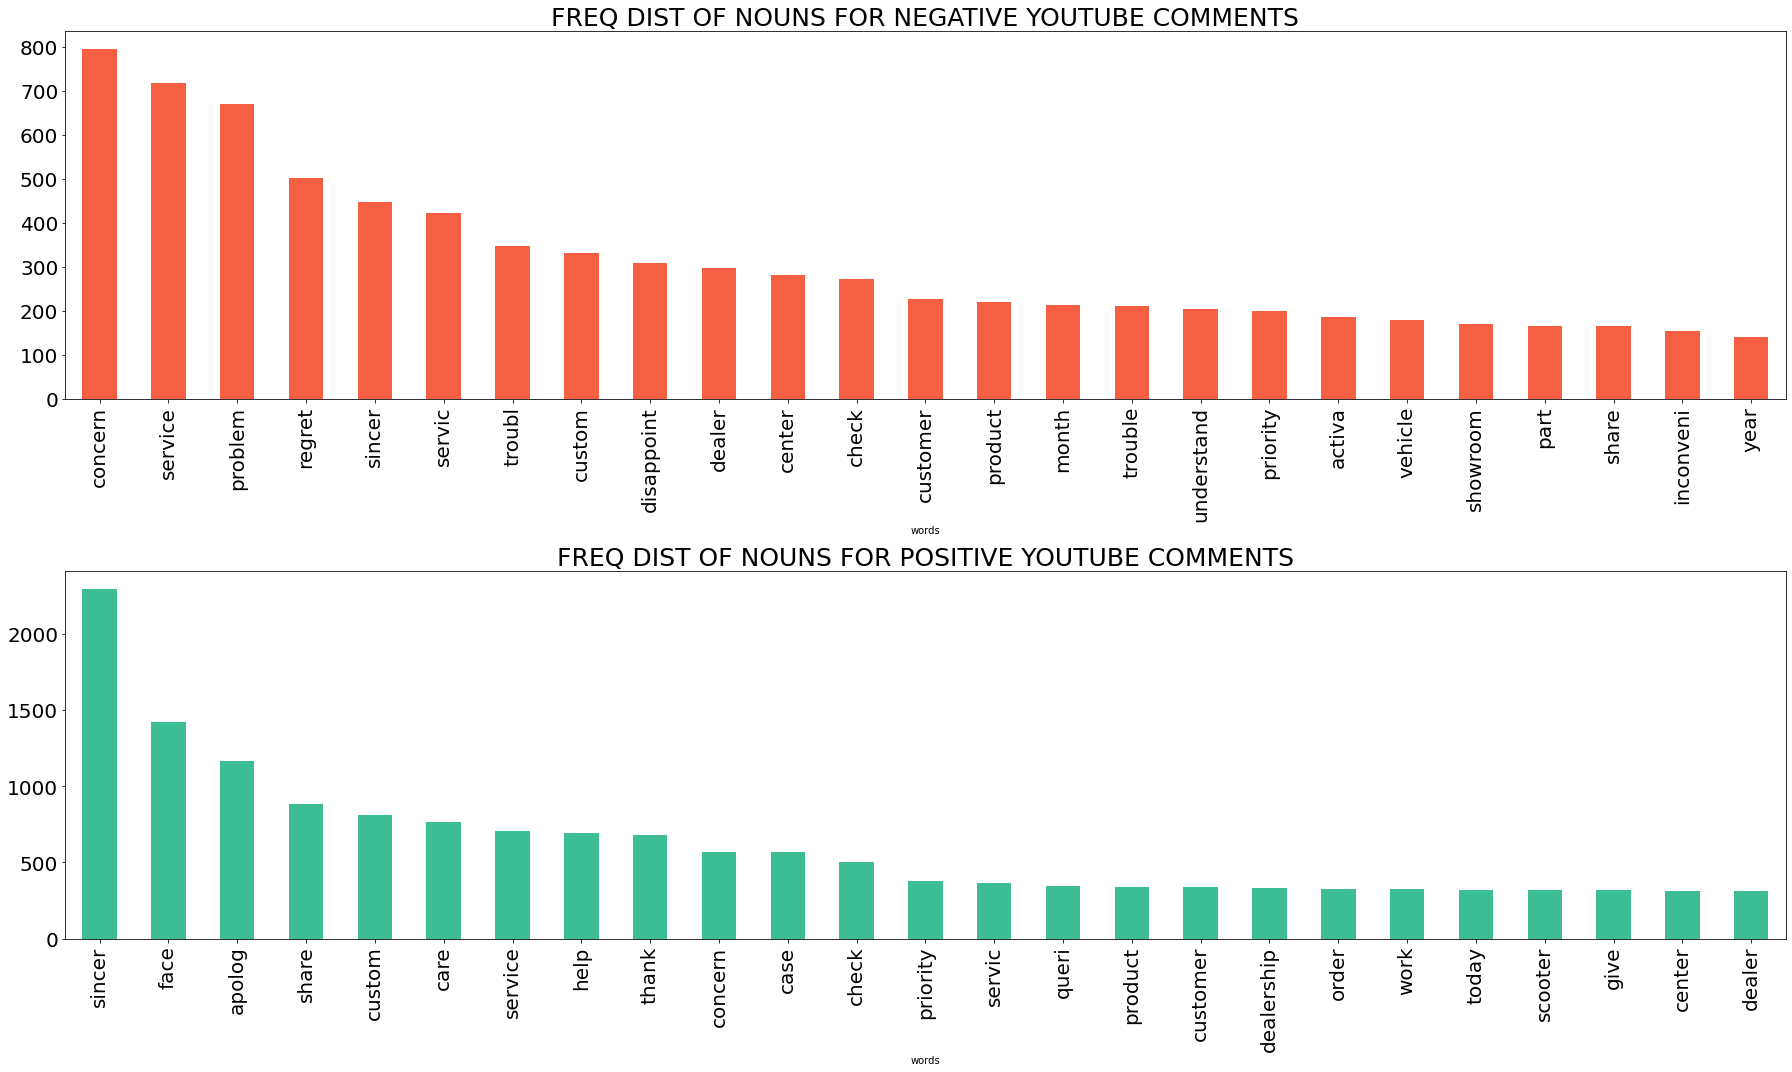

In [280]:
freqdists = [neg_dist_tweets_pos,pos_dist_tweets_pos]
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
fig,axes = plt.subplots(2,1,figsize=(25,15))
for i in range(len(freqdists)):
    freqdists[i].head(25).plot.bar(x='words',y='freq',ax=axes[i],color=colors[i])
    axes[i].set_title("FREQ DIST OF NOUNS FOR "+names[i]+" YOUTUBE COMMENTS",fontsize=25)
    #axes[i].set_xlabel('',fontsize=20)
    #axes[i].set_ylabel('Count',fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

# Topic Modeling

In [192]:
def clean_text1(line):
    
    '''
    Function to clean text without stemming
    '''
    # Removing links,special characters, etc. using regular expressions
    text = re.sub("#[A-Za-z0-9]+"," ",line) # Removing hashtags first
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",text)
    tokens = text.lower().strip().split()  #strip() removes white spaces before and after the text
    terms = [term for term in tokens \
               if term not in stop_updated and \
               len(term)>2]
    return ' '.join(terms)

###### tf-idf is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus

TERM FREQUENCY: tf= the term frequency is the number of times a word appears in a document
DOCUMENT FREQUENCY: df = the ratio of the no of documents containing a word(dw) to the total no of documents(d). df = dw/d
INVERSE DOCUMENT FREQUENCY: idf = log of the ratio of the total no of documents to the total occurrences of a word in all documents. idf = ln(1/df)+1
tfidf = tf * idf

In [194]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [195]:
# PRECOVID TWEETS

pre_covid_tweets['Cleaned_text'] = pre_covid_tweets['Tweet_text'].apply(clean_text1)

df_nouns = pd.DataFrame([])

for comment in list(pre_covid_tweets['Cleaned_text']):

    all_terms = word_tokenize(comment)
    tagged = nltk.pos_tag(all_terms)
    result = [w1 for (w1, t1) in tagged if t1 == "NN"] #Extracting nouns only from comments
    text = [" ".join(result)]
    df_nouns = df_nouns.append(text)

df_nouns.rename(columns = {0:'Noun Comment'}, inplace = True)
df_nouns = df_nouns.reset_index(drop=True)
    
tfidf_vect = TfidfVectorizer(stop_words=stop_updated,max_features=5000)
X = tfidf_vect.fit_transform(df_nouns['Noun Comment'])
tfidf = pd.DataFrame(X.toarray(), columns=tfidf_vect.get_feature_names())

# get feature names
feature_names = np.array(tfidf_vect.get_feature_names())

# find maximum value for each of the features over all of dataset:
max_val = X.max(axis=0).toarray().ravel()

#sort weights from smallest to biggest and extract their indices 
sort_by_tfidf = max_val.argsort()

print("Features with lowest tfidf:\n{}".format(feature_names[sort_by_tfidf[:5]]))
print("\nFeatures with highest tfidf: \n{}".format(feature_names[sort_by_tfidf[-5:]]))

# FITTING THE MODEL

tfidf_norm = normalize(tfidf, norm='l1', axis=1)

num_topics=10

#obtain a NMF model.
model = NMF(n_components=num_topics,beta_loss="kullback-leibler",solver="mu",max_iter=300);
#fit the model
model.fit(tfidf_norm)

C:\Users\DALVENDRA\1\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'care', 'center', 'custom', 'customer', 'itchi', 'service', 'twowheeler', 'wheeer'] not in stop_words.



Features with lowest tfidf:
['baaki' 'chaho' 'dono' 'aapka' 'hath']

Features with highest tfidf: 
['skool' 'proud' 'meter' 'till' 'blade']


NMF(beta_loss='kullback-leibler', max_iter=300, n_components=10, solver='mu')

In [196]:
get_nmf_topics(model,20)

NameError: name 'get_nmf_topics' is not defined